<div class="alert alert-block alert-info">
<b>⚠️ATENCIÓN⚠️</b> <a class="tocSkip"></a><br>
    
Este proyecto utiliza el modelo BERT.

# Introducción

Film Junky Union, una comunidad innovadora para amantes del cine clásico, busca transformar la experiencia de sus usuarios mediante un sistema inteligente que filtre y clasifique automáticamente las reseñas de películas. El objetivo principal es desarrollar un modelo capaz de identificar de manera precisa las críticas negativas, permitiendo así una mejor gestión y visualización de los comentarios dentro de la plataforma.

Para alcanzar este propósito, se empleará un extenso conjunto de datos de reseñas de películas provenientes de IMDB, el cual incluye etiquetas de polaridad (positiva o negativa) asociadas a cada reseña. El reto consiste en construir un modelo de clasificación que no solo distinga entre opiniones positivas y negativas, sino que también logre un desempeño sobresaliente, medido por un valor F1 mínimo de 0.85.

# Preparación

Antes de adentrarse en el análisis y modelado de datos, se importaron una serie de librerías especializadas que facilitarán cada etapa del trabajo. Estas herramientas permiten desde la manipulación eficiente de grandes volúmenes de información y la generación de visualizaciones claras, hasta la aplicación de métodos estadísticos y modelos de predicción sofisticados. En la siguiente sección, se procederá a preparar y explorar los datos, utilizando estas librerías para extraer información relevante.

In [1]:
# Instalación de librerías necesarias
#!pip install spacy
#!pip install torch

In [2]:
# Importación de librerías estándar de Python
import math
import re
import time
import contextlib

# Importación de librerías para manejo de datos
import numpy as np
import pandas as pd

# Importación de librerías para visualización
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Importación de librerías para NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
import spacy

# Importación de librerías para aprendizaje automático y modelos
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Importación de librerías para modelos de lenguaje y deep learning
import torch
import transformers
from transformers import BertConfig, BertModel

# Utilidades adicionales
from tqdm.auto import tqdm

In [3]:
# Descarga de paqueterías de nltk para el preprocesamiento de texto
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Descarga de paqueterías de spacy para el preprocesamiento de texto
spacy.cli.download('en_core_web_sm')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.7 MB/s eta 0:00:000:00:010:00:0101
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


El siguiente código configura el entorno de trabajo para facilitar la visualización y el seguimiento del progreso en análisis de datos dentro de un Jupyter Notebook.

In [4]:
# Configuración de Jupyter y formato de gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Configuración de estilos gráficos
plt.style.use('seaborn-v0_8')
sns.set_style("darkgrid")

# Configuración de progreso para pandas
tqdm.pandas()

# Carga de datos

Los datos fueron proporcionados por Andrew L. Maas, et at. (2011). *Learning Word Vectors for Sentiment Analysis*. Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

In [5]:
# Carga de datos
try:
    df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
# Información sobre el conjunto de datos
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

A continuación se realizará un análisis inicial del conjunto de datos df_reviews, mostrando su estructura y tipos de datos. Luego, se identificará si existen observaciones duplicadas para evaluar la calidad de los datos. Finalmente, se comparará la cantidad de títulos únicos con la cantidad de identificadores únicos de películas, lo que ayudará a detectar posibles inconsistencias o relaciones uno a uno entre títulos y películas.

In [7]:
# Búsqueda de observaciones duplicadas
print(df_reviews.duplicated().sum(), 'observaciones duplicadas')

0 observaciones duplicadas


In [8]:
# Conteo de títulos únicos vs identificadores únicos
print('Títulos únicos:', df_reviews.primary_title.nunique())
print('Identificadores de película únicos:', df_reviews.tconst.nunique())

Títulos únicos: 6555
Identificadores de película únicos: 6648


La discrepancia entre la cantidad de títulos únicos (`primary_title`) y los identificadores únicos de película (`tconst`) se debe a que un mismo título puede estar asociado a múltiples reseñas, lo que genera varias entradas con el mismo `primary_title` pero con identificadores únicos distintos o repetidos.

Previamente identificamos que las `columnas end_year` y `runtime_minutes`, que deberían contener valores numéricos enteros (`int64`), están almacenadas como tipo `object`. Esto se debe a la presencia de caracteres no numéricos, como símbolos de dólar ($), dentro de sus celdas. Para facilitar la conversión correcta a formato numérico, se reemplazan estos valores no válidos por `NaN` (valores faltantes), lo que permitirá posteriormente limpiar y corregir los datos de forma adecuada.

In [9]:
# Conversión de 'end_year' a tipo numérico, forzando los errores a NaN
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

# Conversión de 'end_year' a tipo numérico, forzando los errores a NaN
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

# Verificación de cambios
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,NaN,25.0,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [10]:
# Generación de tabla con número de NaN y porcentaje
counts = df_reviews.isnull().sum()
percent = (counts / len(df_reviews)) * 100

null_summary = pd.DataFrame({
        'conteo de NaN': counts,
        'porcentaje de NaN': percent.round(2)})

null_summary

,conteo de NaN,porcentaje de NaN
tconst,0,0.00
title_type,0,0.00
primary_title,0,0.00
original_title,0,0.00
start_year,0,0.00
end_year,45052,95.18
runtime_minutes,488,1.03
is_adult,0,0.00
genres,0,0.00
average_rating,2,0.00


Debido a la alta proporción de datos faltantes o incorrectos en la columna `'end year'`, y considerando que esta información no es relevante para los objetivos planteados en este estudio, se opta por eliminar dicha columna del conjunto de datos.

In [11]:
# Eliminación de la columna 'end_year'
df_reviews = df_reviews.drop(['end_year'], axis=1)

Los valores faltantes en la columna `'runtime_minutes'` serán imputados utilizando la media de las duraciones de las demás películas presentes en esa misma columna.

In [12]:
# Cálculo de la media de la columna
mean_runtime = round(df_reviews['runtime_minutes'].mean(),1)

# Reemplazo de valores NaN (originalmente '\N') con la media
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].fillna(mean_runtime)

Buscamos qué filas tienen aún datos ausentes. 

In [13]:
# Revisión de observaciones restantes con NaN
df_reviews[df_reviews.isnull().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,98.8,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,98.8,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Se opta por eliminar estas dos observaciones debido a que no es posible recuperar los datos faltantes, ni siquiera consultando la base de datos original de IMDb. Esta decisión se fundamenta en que mantener registros incompletos o irrecuperables puede afectar la calidad y confiabilidad del análisis posterior, por lo que es preferible descartarlos para asegurar la integridad del conjunto de datos.

In [14]:
# Eliminación de observaciones restantes con NaN
df_reviews = df_reviews.dropna()

In [15]:
# Observaciones con NaN
print('Observaciones con NaN:', df_reviews.isnull().any(axis=1).sum())

Observaciones con NaN: 0


In [16]:
# Revisión final
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   runtime_minutes  47329 non-null  float64
 6   is_adult         47329 non-null  int64  
 7   genres           47329 non-null  object 
 8   average_rating   47329 non-null  float64
 9   votes            47329 non-null  Int64  
 10  review           47329 non-null  object 
 11  rating           47329 non-null  int64  
 12  sp               47329 non-null  object 
 13  pos              47329 non-null  int64  
 14  ds_part          47329 non-null  object 
 15  idx              47329 non-null  int64  
dtypes: Int64(1), float64(2), int64(5), object(8)
memory usage: 6.2+

Tras eliminar las dos filas con `NaN` restantes, el conjunto de datos quedó conformado por 47,329 observaciones y 16 variables. Además, se verificó que no existen valores faltantes, registros repetidos ni errores en la asignación de tipos de datos, garantizando así la calidad y consistencia del dataset para análisis posteriores.

# Análisis Exploratorio de Datos

El siguiente código genera un resumen de estadísticas descriptivas para las variables numéricas del conjunto de datos. Esta operación permite obtener una visión general sobre la distribución, tendencia central y dispersión de los datos, ayudando a identificar posibles valores atípicos o patrones relevantes.

In [17]:
# Estadística descriptivas resumidas
round(df_reviews.describe(),2)

,start_year,runtime_minutes,is_adult,average_rating,votes,rating,pos,idx
count,47329.00,47329.00,47329.00,47329.00,47329.0,47329.00,47329.0,47329.00
mean,1989.63,98.76,0.00,6.00,25562.92,5.48,0.5,6279.83
std,19.60,38.13,0.04,1.49,83670.04,3.47,0.5,3605.72
min,1894.00,1.00,0.00,1.40,9.0,1.00,0.0,0.00
25%,1982.00,87.00,0.00,5.10,827.0,2.00,0.0,3162.00
50%,1998.00,95.00,0.00,6.30,3197.0,4.00,0.0,6300.00
75%,2004.00,109.00,0.00,7.10,13974.0,9.00,1.0,9412.00
max,2010.00,1140.00,1.00,9.70,1739448.0,10.00,1.0,12499.00


A continuación se generarán dos gráficos para analizar la evolución temporal de la producción y recepción de películas. El primer gráfico muestra el número anual de películas filmadas, mientras que el segundo presenta la cantidad de reseñas positivas y negativas por año, junto con una media móvil de cinco años del promedio de reseñas por película. Esta visualización combinada permite identificar tendencias en la producción cinematográfica y en la percepción del público a lo largo del tiempo.

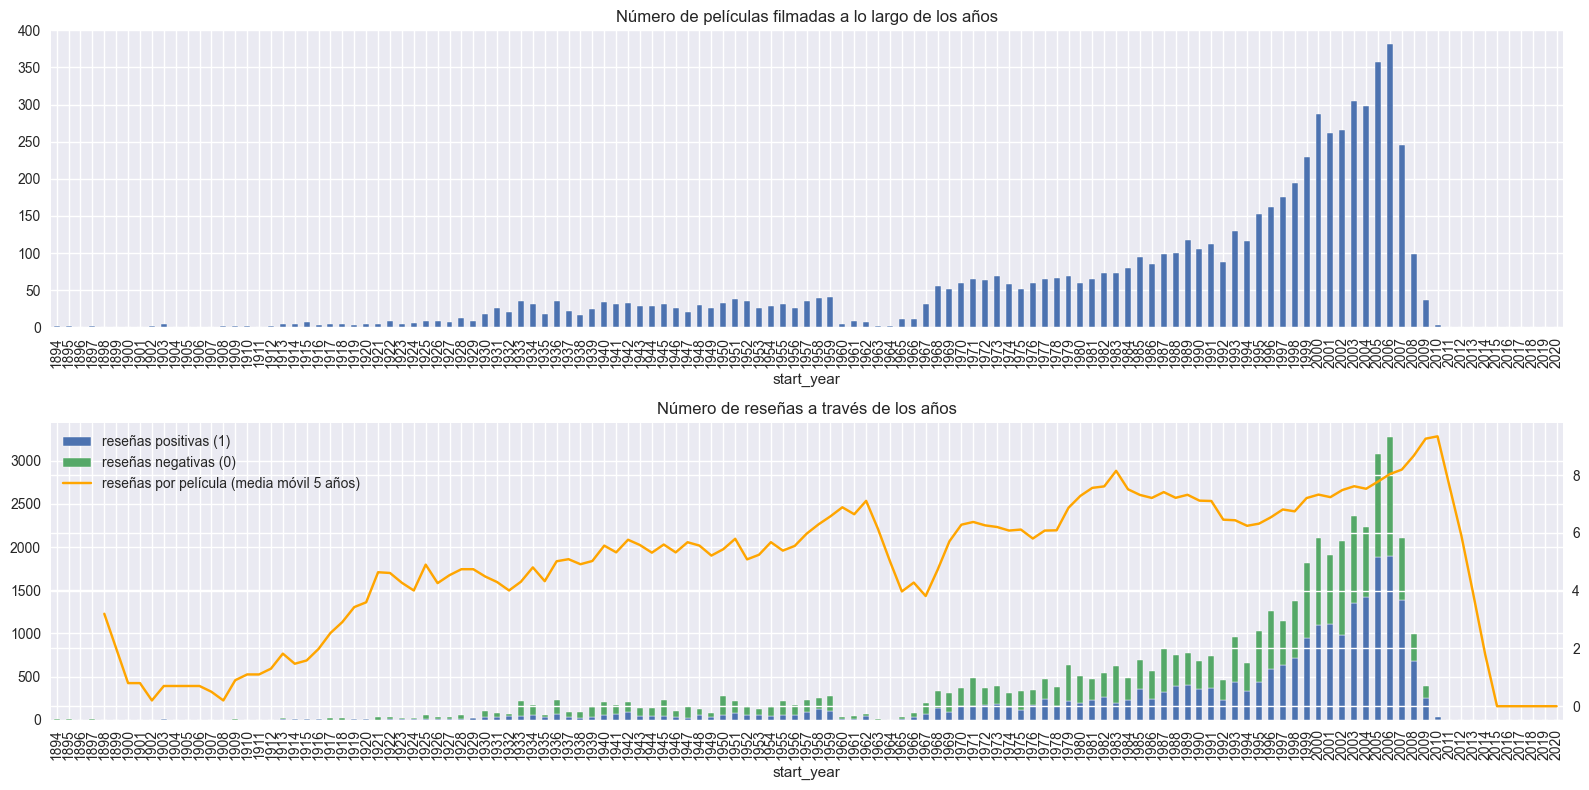

In [18]:
# Figura y ejes
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico 1: Número de películas filmadas a lo largo de los años
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas filmadas a lo largo de los años')

# Gráfico 2: Número de reseñas positivas y negativas a través de los años y promedio de reseñas por película
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, ax=ax)

# Leyenda personalizada para reseñas positivas y negativas
lines1, labels1 = ax.get_legend_handles_labels()
labels1 = ['reseñas positivas (1)', 'reseñas negativas (0)']

# Cálculo del promedio de reseñas por película (media móvil de 5 años)
dft2_total = df_reviews['start_year'].value_counts().sort_index()
dft2_total = dft2_total.reindex(index=np.arange(dft2_total.index.min(), 
                                                max(dft2_total.index.max(), 2021))).fillna(0)
dft3 = (dft2_total / dft1).fillna(0)

# Eje secundario para la media móvil de reseñas por película
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
                                                   label='reseñas por película (media móvil 5 años)', 
                                                   ax=axt)

# Combinación de leyendas de ambos ejes
lines2, labels2 = axt.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a través de los años')

# Ajuste del layout
fig.tight_layout()

* **Crecimiento sostenido en la producción de películas:** Desde 1894 hasta alrededor de 2010, se observa un crecimiento constante y acelerado en el número de películas filmadas anualmente, con un aumento especialmente pronunciado a partir de la década de 1980. El pico máximo de producción se alcanza justo antes de 2010, seguido de una caída abrupta en los años posteriores, lo cual puede deberse a datos incompletos para esos años.

* **Incremento en la cantidad de reseñas:** El número de reseñas (tanto positivas como negativas) por año crece de forma significativa a partir de los años 1980, en paralelo con el aumento en la producción de películas. Esto sugiere una mayor interacción del público con el cine, posiblemente impulsada por la llegada de internet y plataformas de reseñas.

* **Predominio de reseñas positivas:** Aunque ambas categorías crecen, las reseñas positivas superan consistentemente en cantidad a las negativas, lo que puede indicar una tendencia general a valorar favorablemente las películas o un sesgo en los usuarios que tienden a dejar reseñas.

* **Estabilidad en la media de reseñas por película:** La línea amarilla, que representa la media móvil de reseñas por película con una ventana de 5 años, muestra una tendencia relativamente estable (con algunos altibajos) desde mediados del siglo XX hasta 2010. Esto indica que, aunque la producción y las reseñas totales aumentan, la proporción de reseñas por película se mantiene bastante constante.


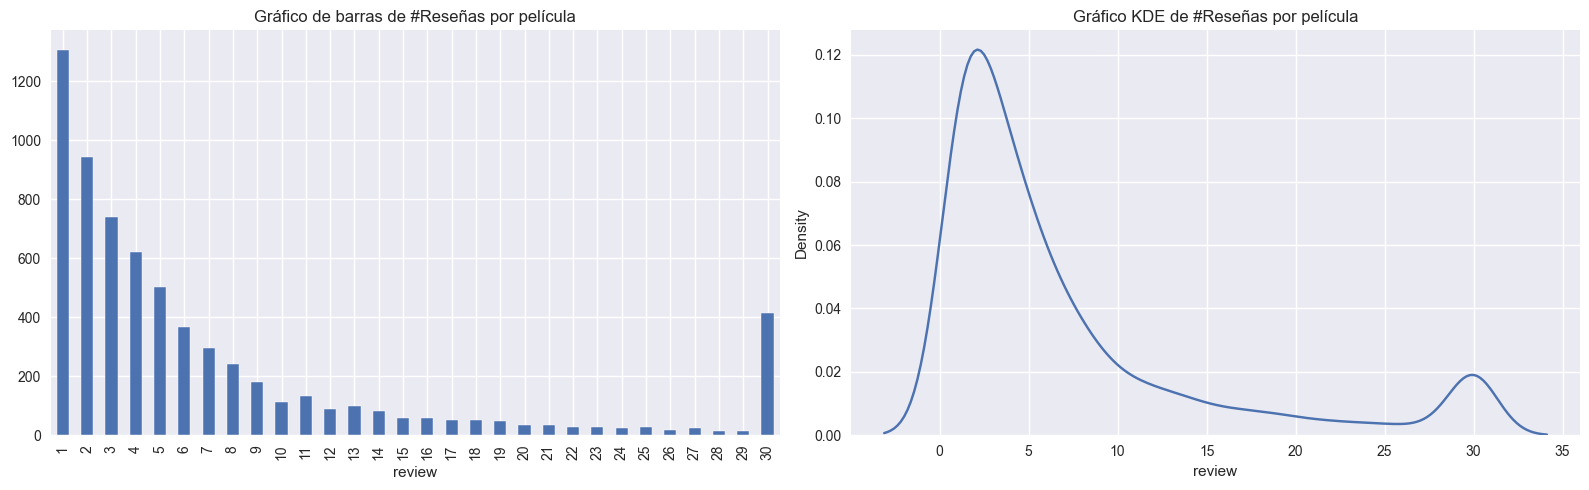

In [19]:
# Figura y subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de barras: Número de reseñas por película
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

# Gráfico KDE: Distribución del número de reseñas por película
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

# Ajuste del layout
fig.tight_layout()

En el gráfico de barras (izquierda) se muestra el número de películas (eje y) según la cantidad específica de reseñas que tienen (eje x). Se observa una distribución discreta: la mayoría de las películas tienen pocas reseñas, mientras que muy pocas alcanzan valores altos. Destaca un pico en 1 reseña, con más de 1,200 películas, seguido de una caída rápida conforme aumenta el número de reseñas. Además, hay un aumento atípico alrededor de 30 reseñas, lo que podría indicar un límite artificial, un error en los datos o una característica particular del conjunto.

En el gráfico KDE (derecha) se presenta una estimación suave de la densidad de la distribución de reseñas por película, lo que facilita identificar la forma general de la distribución. Se confirma que la mayoría de las películas tienen entre 1 y 5 reseñas. También se observa un segundo pico alrededor de 30 reseñas, corroborando la anomalía detectada en el gráfico de barras y mostrando la tendencia general del número de reseñas por película.

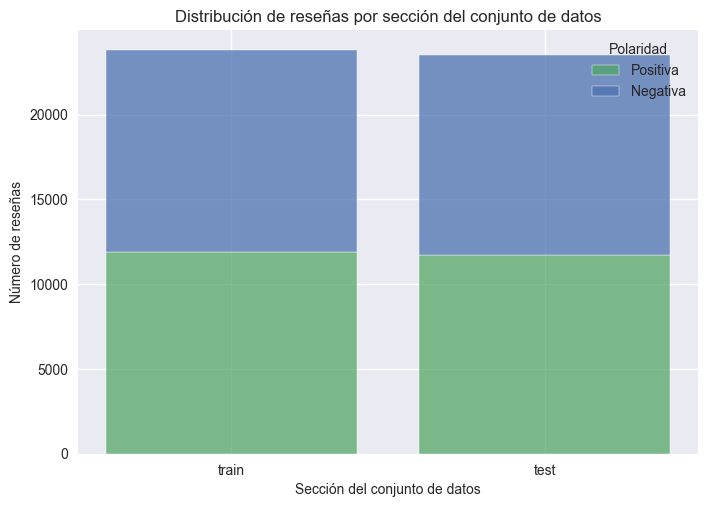

In [20]:
# Visualización: Histograma apilado por polaridad y sección del conjunto de datos
g = sns.histplot(data=df_reviews, x='ds_part', hue='pos', multiple='stack', shrink=.8)

# Configuración de etiquetas de los ejes
plt.xlabel('Sección del conjunto de datos', fontsize=10)
plt.ylabel('Número de reseñas', fontsize=10)

# Leyendas y título
plt.legend(title='Polaridad', loc='upper right', labels=['Positiva', 'Negativa'])
plt.title('Distribución de reseñas por sección del conjunto de datos', fontsize=12)

# Mostrar gráfico
plt.show()

A partir de la gráfica, observamos que las reseñas positivas y negativas están distribuidas casi en proporciones iguales (50:50) tanto en el conjunto de entrenamiento como en el de prueba. Esta distribución balanceada es fundamental para garantizar un entrenamiento equitativo y evitar sesgos en los modelos a evaluar.

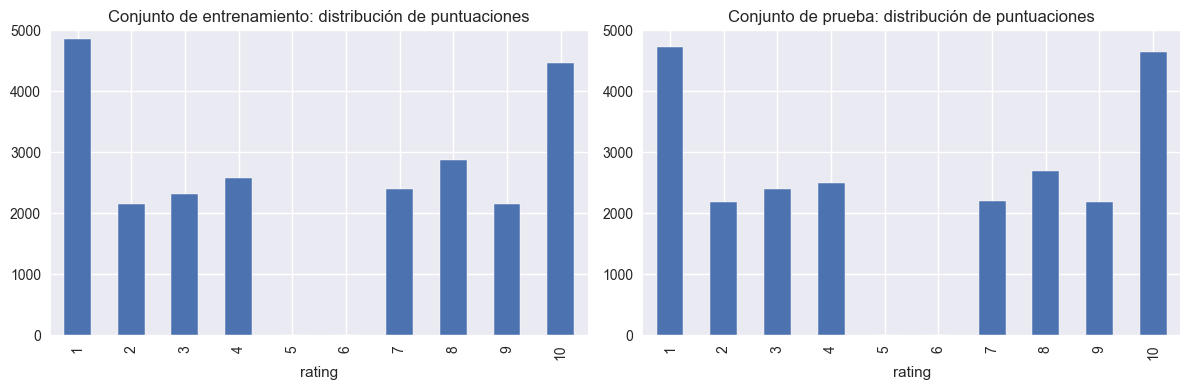

In [21]:
# Figura y ejes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1: Distribución de puntuaciones en el conjunto de entrenamiento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de entrenamiento: distribución de puntuaciones')

# Gráfico 2: Distribución de puntuaciones en el conjunto de prueba
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de prueba: distribución de puntuaciones')

# Ajuste del layout
fig.tight_layout()

Las reseñas seleccionadas parecen provenir únicamente de personas que calificaron las películas con puntuaciones entre 1 y 4, o entre 7 y 10; no hay reseñas con calificaciones de 5 o 6 en este conjunto de datos. Si bien esto puede facilitar la construcción de modelos de clasificación binaria, introduce un sesgo importante: en escenarios reales, las calificaciones de 5 o 6 suelen corresponder a opiniones mixtas o neutras, que no están representadas aquí. Afortunadamente, en este proyecto las predicciones se basarán en el texto de las reseñas y no en las puntuaciones numéricas. Por lo tanto, aunque este sesgo debe ser tenido en cuenta, no invalida la utilidad del conjunto de datos para el objetivo planteado.

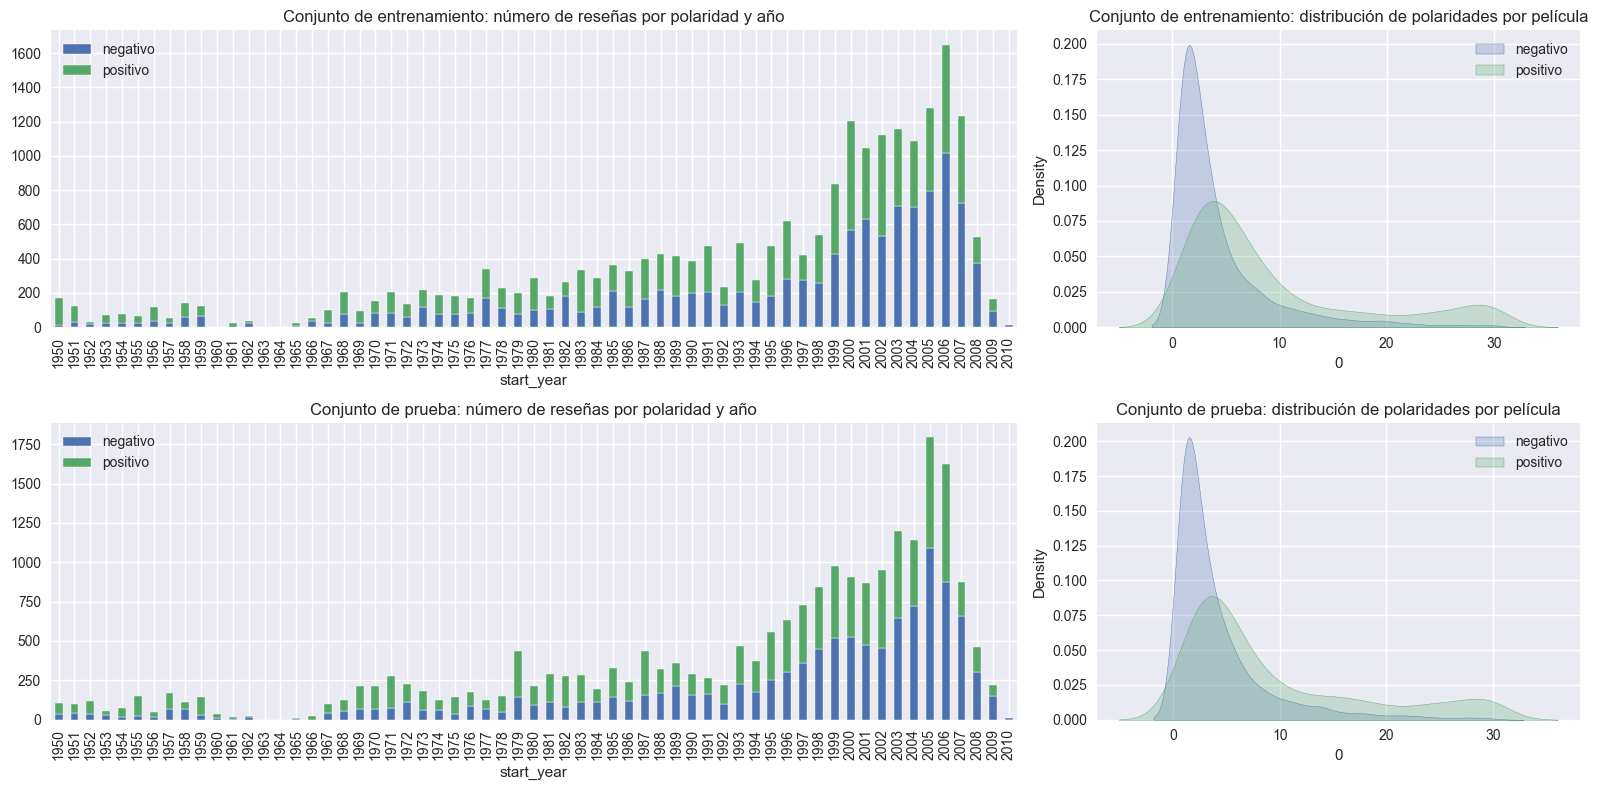

In [22]:
# Creación de la figura y subplots con proporciones personalizadas
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Gráfico 1: Número de reseñas positivas y negativas por año en el conjunto de entrenamiento
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.loc[1950:2010].plot(kind='bar', stacked=True, ax=ax)
ax.legend(['negativo', 'positivo'])
ax.set_title('Conjunto de entrenamiento: número de reseñas por polaridad y año')

# Gráfico 2: Distribución de reseñas positivas y negativas por película en el conjunto de entrenamiento
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], label='negativo', ax=ax, fill=True)
sns.kdeplot(dft[1], label='positivo', ax=ax, fill=True)
ax.legend()
ax.set_title('Conjunto de entrenamiento: distribución de polaridades por película')

# Gráfico 3: Número de reseñas positivas y negativas por año en el conjunto de prueba
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.loc[1950:2010].plot(kind='bar', stacked=True, ax=ax)
ax.legend(['negativo', 'positivo'])
ax.set_title('Conjunto de prueba: número de reseñas por polaridad y año')

# Gráfico 4: Distribución de reseñas positivas y negativas por película en el conjunto de prueba
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], label='negativo', ax=ax, fill=True)
sns.kdeplot(dft[1], label='positivo', ax=ax, fill=True)
ax.legend()
ax.set_title('Conjunto de prueba: distribución de polaridades por película')

# Ajuste del layout
fig.tight_layout()

**Tendencia temporal (gráficos de barras, izquierda):** Hay un claro aumento en el número de reseñas (tanto positivas como negativas) a lo largo de las décadas, especialmente desde los años 90 hasta 2008-2007, donde se alcanza el pico. El número de reseñas cae abruptamente después de 2008, probablemente por falta de datos más recientes o por el corte del dataset. En la mayoría de los años, las reseñas negativas (azul) y positivas (verde) están relativamente balanceadas, aunque en los últimos años del rango parece haber una ligera preponderancia de reseñas positivas. La distribución temporal es consistente entre el conjunto de entrenamiento (arriba) y el de prueba (abajo), lo cual es positivo para la representatividad de ambos conjuntos.

**Distribución de polaridades por película (KDE, derecha):** La mayoría de las películas tienen pocas reseñas, con un pico muy marcado en valores bajos (cerca de 1 reseña). Hay una cola larga hacia la derecha, indicando que unas pocas películas reciben muchas reseñas. Se observa un ligero sesgo hacia más reseñas negativas en el pico principal, pero las positivas predominan en la cola (más reseñas por película). La forma de la distribución es muy similar entre entrenamiento y prueba, lo que indica que la división de los datos fue adecuada y no introduce sesgos significativos.


# Preparativos para el Modelado

## Definición de funciones auxiliares

### Función de evaluación de modelos

Este código sirve para probar y medir qué tan bien funciona un modelo de predicción. Primero, entrena el modelo con datos conocidos y luego evalúa qué tan acertadas son sus predicciones en datos nuevos. Calcula varias métricas importantes, como la precisión y la capacidad de distinguir entre clases, y genera gráficos que muestran cómo cambia el rendimiento según diferentes niveles de decisión. Así, permite entender y comparar el comportamiento del modelo antes de usarlo en situaciones reales.

In [23]:
# Creación de df para resumen de modelos
summary_models = pd.DataFrame(columns=['modelo', 'NPL', 'F1 entrenamiento', 
                                       'F1 prueba', 'Tiempo de predicción']).set_index('modelo')

# Función de evaluación para modelos
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    # Diccionario para almacenar estadísticas de evaluación
    eval_stats = {}

    # Creación de figura con 3 subplots para F1, ROC y PRC
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Evaluación para conjuntos train y test
    for type, features, target in (('entrenamiento', train_features, train_target), 
                                   ('prueba', test_features, test_target)):
        eval_stats[type] = {}    

        # Entrenamiento del modelo
        model.fit(train_features, train_target)
        
        # Predicciones y probabilidades
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # Cálculo de valores F1 para distintos umbrales
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >=threshold) for threshold in f1_thresholds]

        # Curva ROC y AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva Precision-Recall y Average Precision Score (APS)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Color para gráficos: azul para train, verde para test
        color = 'blue' if type == 'entrenamiento' else 'green'

        # Gráfico Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Marcadores para umbrales específicos        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('umbral')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva F1') 
        
        # Gráfico Curva ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # Marcadores para umbrales específicos
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')
        
        # Gráfico Curva Precision-Recall (PRC)
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Marcadores para umbrales específicos
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva PRC')
                
        # Métricas adicionales
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    # Creación de DataFrame con métricas redondeadas y ordenadas
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Exactitud', 'F1', 'APS', 'ROC AUC'])

    # Muestra de métricas
    print(df_eval_stats)

    return df_eval_stats

### Función para búsqueda de mejores parámetros

Este código busca automáticamente la mejor combinación de opciones para un modelo de aprendizaje automático, probando diferentes configuraciones y evaluándolas varias veces con distintos grupos de datos. Al final, muestra cuáles son los parámetros que permiten al modelo obtener el mejor desempeño según una medida específica.

In [24]:
# Función para búsqueda de mejores parámetros con validación cruzada
def grid_search_cv(estimator, params, X, y, random_state=12345):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        scoring='f1',
        n_jobs=1, 
        cv=5)
    
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    print(f'Mejores parámetros para {estimator.__class__.__name__}: {best_params}')
    return best_params

### Función de normalización de texto

Este código toma un texto, elimina todos los caracteres que no sean letras o apóstrofes, lo convierte a minúsculas, separa las palabras y luego quita las palabras muy comunes que no aportan significado (como "y", "el", "de"). Finalmente, devuelve el texto limpio y apropiado para analizar.

In [25]:
# Función de limpieza y normalización de texto con eliminación de stopwords
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text).lower()
    list_words = text.split()
    stop_words = set(nltk_stopwords.words("english"))
    filtered_words = [word for word in list_words if word not in stop_words]
    text = " ".join(filtered_words) 
    return text

In [26]:
# Creación de columna con reseñas normalizadas
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

# Visualización de cambios
df_reviews[['review', 'review_norm']].sample(10)

,review,review_norm
26318,Pinjar by Mr dwivedi is an awesome movie. Its ...,pinjar mr dwivedi awesome movie definitely gre...
45065,"Almost too well done... ""John Carpenter's Vamp...",almost well done john carpenter's vampires ent...
11011,This film has absolutely no redeeming features...,film absolutely redeeming features even worthy...
36382,This one probably does not fit in the bottom o...,one probably fit bottom barrel mediocre slashe...
43386,Geniuses William Cameron Menzies and Herbert G...,geniuses william cameron menzies herbert georg...
24349,I remember catching this movie on one of the S...,remember catching movie one showtime channels ...
32853,"STMD! is not a terrible movie, but it IS quite...",stmd terrible movie quite forgettable lighting...
45973,"Yes, a tap dancing horror thriller........with...",yes tap dancing horror thriller shelley debbie...
20010,"I rented this movie, knowing that it would be ...",rented movie knowing would bad seen one good d...
23751,People like me will tear this movie apart. It'...,people like tear movie apart realistic plot so...


## Segmentación de conjuntos de entrenamiento y prueba

A continuación se dividen los datos en conjuntos de entrenamiento y prueba. Luego separa las opiniones normalizadas que se usarán como información de entrada y las etiquetas que indican si la opinión es positiva o no.

In [27]:
# Segmentación en conjuntos de entrenamiento y prueba
train = df_reviews.query('ds_part == "train"').copy()
test = df_reviews.query('ds_part == "test"').copy()

# Segmentación de características 
X_train = train['review_norm'].copy()
X_test = test['review_norm'].copy()

# Segmentación de objetivos
y_train = train['pos']
y_test = test['pos']

## Definición de modelos y sus parámetros

A continuación se definen los tres modelos de clasificación que se utilizarán para predecir resultados binarios (positivo/negativo). Para cada modelo, se especifican diferentes opciones o “parámetros” que el programa probará para encontrar la mejor configuración. Los modelos son:

* **Regresión logística**, que estima la probabilidad de un evento usando una fórmula matemática.

* **Bosque aleatorio**, que combina muchos árboles de decisión para mejorar la precisión.

* **LGBM (LightGBM)**, un modelo rápido y eficiente basado en árboles para clasificación.


In [28]:
# Definición de parámetros para Regresión Logística
model_lr = LogisticRegression(random_state=12345)
params_lr = {
    'penalty': ['l1', 'l2'], 
    'C': [0.1, 1.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [2000]
    }

# Definición de parámetros para Bosque Aleatorio
model_rf = RandomForestClassifier(random_state=12345)
params_rf = {'n_estimators': [100, 150],
              'criterion': ["gini", "entropy"],
              'max_depth': [6, 10],
              }

# Definición de parámetros para LGBM
model_lgbm = LGBMClassifier(random_state=12345, verbosity=-1)
params_lgbm = {'objective' : ['binary'], 
               'n_estimators' : [100, 150],
               'max_depth': [5,8] }

# Evaluación de modelos

## Prueba de cordura como línea base

### Modelo 0: Clasificador aleatorio

En la sección de evaluación de modelos, incluimos en primer lugar una prueba de cordura que sirva como referencia básica para validar el desempeño de nuestros clasificadores. Para ello, utilizamos un clasificador aleatorio, como el DummyClassifier con estrategia 'uniform', que asigna etiquetas de forma completamente aleatoria e independiente de los datos. Este modelo simple nos permite establecer un **punto de partida mínimo**: cualquier modelo que desarrollemos debe superar el rendimiento de este clasificador trivial para considerarse útil.

           entrenamiento  prueba
Exactitud            0.5    0.50
F1                   0.5    0.51
APS                  0.5    0.50
ROC AUC              0.5    0.50


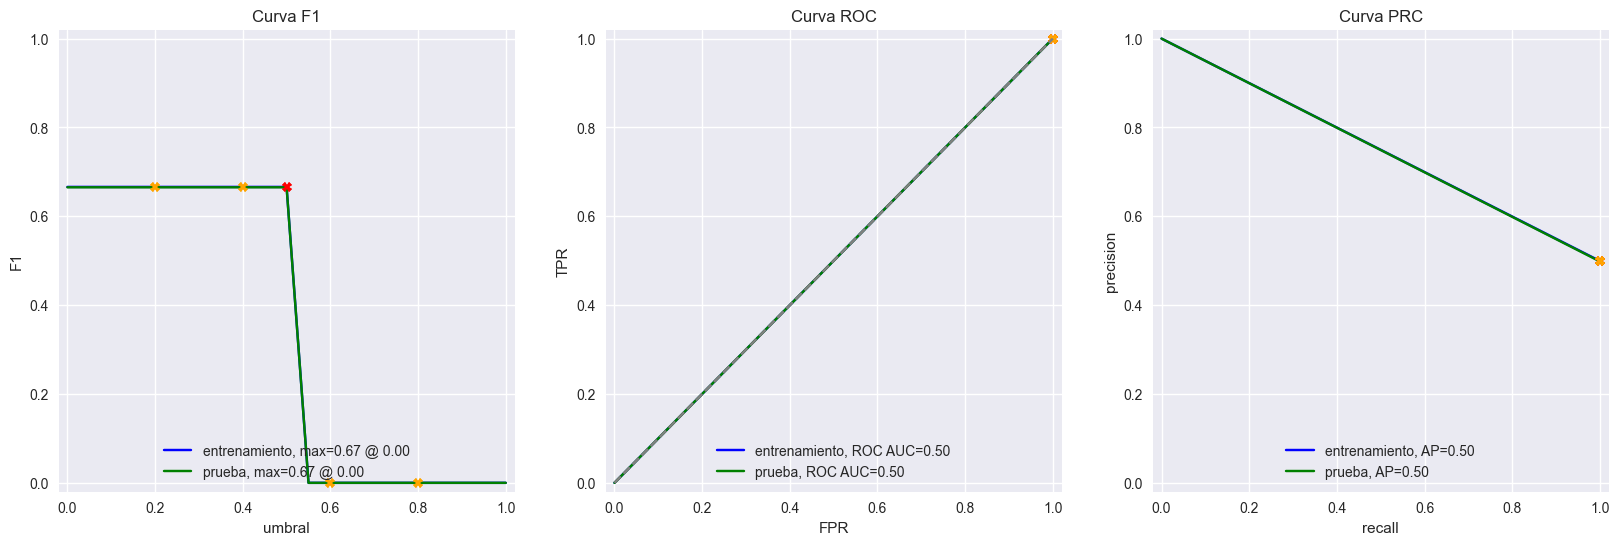

In [29]:
# Entrenamiento y evaluación de un clasificador aleatorio como línea base
model_dummy = DummyClassifier(strategy='uniform')
model_dummy.fit(X_train, y_train)

start_time_0 = time.time()
result_0 = evaluate_model(model_dummy, X_train, y_train, X_test, y_test)
end_time_0 = time.time()
elapsed_time_0 = end_time_0 - start_time_0

# Incorporación de resultados a tabla
summary_models.loc['Modelo o - DummyClassifier'] = {'NPL':'normalizador', 
                                                    'F1 entrenamiento': result_0.iloc[1][0], 
                                                    'F1 prueba': result_0.iloc[1][1],
                                                    'Tiempo de predicción': round(elapsed_time_0, 2)}

**Curva F1:**
En este modelo base, la curva se mantiene constante en 0.67 para umbrales bajos y cae abruptamente a cero al superar un umbral cercano a 0.5. Esto indica que el modelo no distingue bien entre clases y probablemente predice una sola clase para la mayoría de los umbrales. El punto rojo señala el umbral donde se alcanza el máximo F1 (0.67 en umbral 0.00), mientras que los puntos amarillos representan otros umbrales evaluados. La superposición de las curvas de entrenamiento y prueba sugiere que el modelo tiene un desempeño similar en ambos, aunque limitado.

**Curva ROC:**
En este caso, ambas curvas (entrenamiento y prueba) forman una línea diagonal desde (0,0) hasta (1,1), con un área bajo la curva (AUC) de 0.50, equivalente a una clasificación aleatoria.

**Curva PRC:**
La curva de PRC muestra una línea recta descendente desde (0,1) hasta (1,0.5), con curvas de entrenamiento y prueba superpuestas y un promedio de precisión (AP) de 0.50. Esto refleja que el modelo no es capaz de diferenciar entre clases positivas y negativas.

## Modelos con procesamiento de texto NLTK y TF-IDF 

En esta sección de evaluación de modelos para análisis de sentimiento, se aplicará la lematización utilizando la biblioteca NLTK y la vectorización mediante TF-IDF. NLTK (Natural Language Toolkit) es una biblioteca de Python ampliamente utilizada en procesamiento de lenguaje natural que ofrece una gran variedad de herramientas y recursos, como WordNet, para realizar tareas como la lematización, que consiste en reducir las palabras a su forma base o lema, facilitando la normalización del texto. Aunque NLTK es muy flexible y adecuada para investigación, puede ser menos eficiente en velocidad y precisión en algunos idiomas. Por su parte, la vectorización TF-IDF (Term Frequency-Inverse Document Frequency) convierte el texto en vectores numéricos que reflejan la importancia relativa de cada término en un documento respecto al conjunto total, permitiendo que los modelos de aprendizaje automático interpreten el contenido textual de forma cuantitativa. La combinación de estas técnicas mejora la calidad de las representaciones textuales y, en consecuencia, la precisión y robustez de los modelos de predicción de sentimiento.

In [30]:
# Preprocesamiento de texto: eliminación de stopwords y lematización con NLTK
def lemmatizer_nltk(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [31]:
# Lematización
start_time_nltk = time.time()
X_train_lemm_nltk = X_train.progress_apply(lemmatizer_nltk)
X_test_lemm_nltk = X_test.progress_apply(lemmatizer_nltk)
end_time_nltk = time.time()
elapsed_time_nltk = end_time_nltk - start_time_nltk

# TF-IDF
vectorizer_nltk = TfidfVectorizer()
X_train_nltk = vectorizer_nltk.fit_transform(X_train_lemm_nltk)
X_test_nltk  = vectorizer_nltk.transform(X_test_lemm_nltk)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [32]:
#Visualización de resultados de lematización y resumen de matrices TF-IDF
print('Ejemplo de texto original:\n', train['review'].iloc[100])
print('\nEjemplo de texto lematizado con NTLK:\n', X_train_lemm_nltk.iloc[100])
print()
print('Tiempo de lematización:', round(elapsed_time_nltk,2), 'seg')
print('TF-IDF Matrix X train', X_train_nltk.shape)
print('TF-IDF Matrix X test:', X_test_nltk.shape)

Ejemplo de texto original:
 The plot of this terrible film is so convoluted I've put the spoiler warning up because I'm unsure if I'm giving anything away. The audience first sees some man in Jack the Ripper garb murder an old man in an alley a hundred years ago. Then we're up to modern day and a young Australian couple is looking for a house. We're given an unbelievably long tour of this house and the husband sees a figure in an old mirror. Some 105 year old woman lived there. There are also large iron panels covering a wall in the den. An old fashioned straight-razor falls out when they're renovating and the husband keeps it. I guess he becomes possessed by the razor because he starts having weird dreams. Oh yeah, the couple is unable to have a baby because the husband is firing blanks. Some mold seems to be climbing up the wall after the couple removes the iron panels and the mold has the shape of a person. Late in the story there is a plot about a large cache of money & the husband

Después de eliminar las palabras irrelevantes mediante stopwords, NLTK trató todas las palabras como si fueran sustantivos debido a que no se utilizaron etiquetas de partes del habla (POS), lo que provocó que no lematizara correctamente términos como *convoluted* (adjetivo), *giving* (verbo) o *seems*Aunque no se utilizaron etiquetas de partes del habla (POS), observamos que spaCy realizó una lematización más precisa que la herramienta anterior. Por ejemplo, palabras como convoluted, giving y seems, que no fueron correctamente lematizadas previamente, fueron transformadas adecuadamente por spaCy a sus formas base: convolute, give y seem, respectivamente. Esto se debe a que spaCy incorpora modelos estadísticos y reglas lingüísticas que, incluso sin etiquetas POS explícitas, permiten una mejor identificación del lema correcto en inglés. En contraste, otras herramientas pueden depender más estrictamente del etiquetado POS para una lematización precisa, lo que limita su desempeño cuando estas etiquetas no están disponibles. (verbo), ya que no reconoce las distintas formas verbales ni sus conjugaciones. En algunos casos, como *firing* que se lematizó a *fire*, la coincidencia fue casual, dado que el verbo y el sustantivo comparten la misma raíz. Esta limitación puede afectar ligeramente la precisión de los modelos de predicción.

### Modelo 1: LogisticRegressionClassifier

El primer modelo será una **regresión logística**. En primer lugar, se optimizarán sus hiperparámetros mediante validación cruzada. Posteriormente, se evaluará el modelo utilizando los conjuntos de entrenamiento y prueba, cuyos textos han sido previamente lematizados con NLTK y vectorizados mediante TF-IDF.

In [33]:
# Búsqueda y entrenamiento del mejor modelo
best_params_1lr = grid_search_cv(model_lr, params_lr, X_train_nltk, y_train)
best_model_1lr = LogisticRegression(**best_params_1lr)
print()

Mejores parámetros para LogisticRegression: {'C': 1.0, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}



           entrenamiento  prueba
Exactitud           0.94    0.88
F1                  0.94    0.88
APS                 0.98    0.95
ROC AUC             0.98    0.95



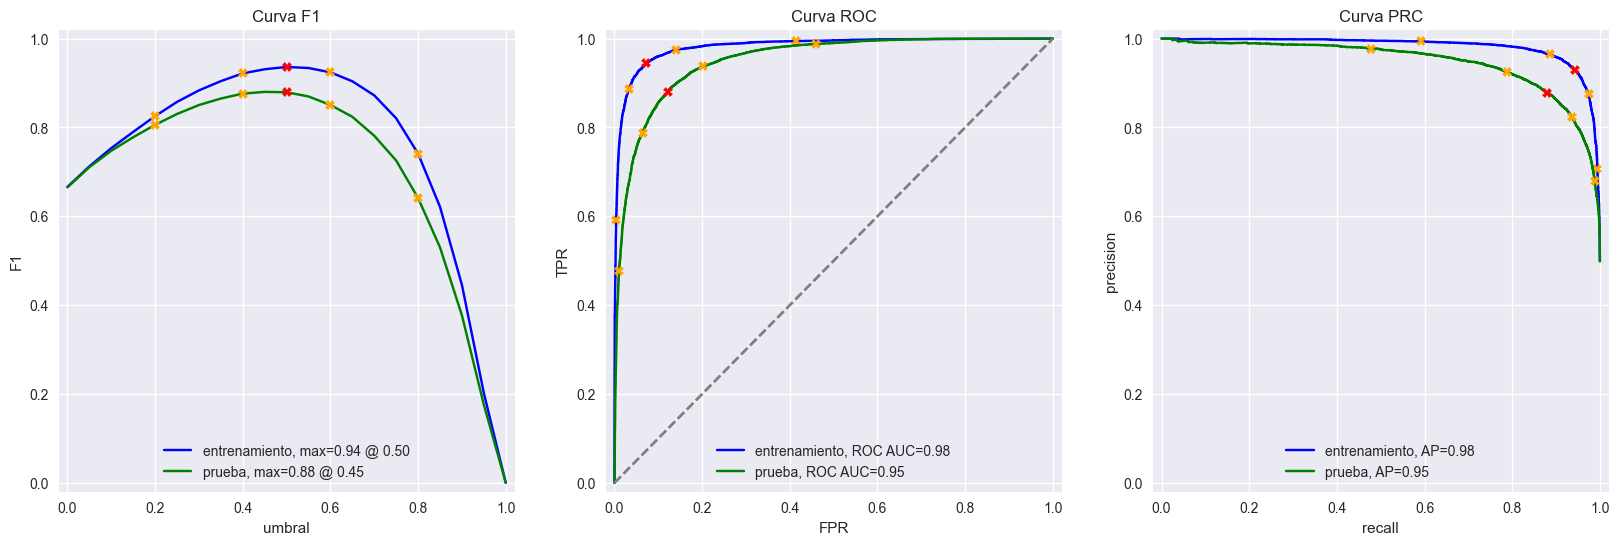

In [34]:
# Evaluación del mejor modelo
start_time_1 = time.time()
result_1 = evaluate_model(best_model_1lr, X_train_nltk, y_train, X_test_nltk, y_test)
end_time_1 = time.time()
elapsed_time_1 = end_time_1 - start_time_1
print()

# Incorporación de resultados a tabla
summary_models.loc['Modelo 1 - LogisticRegression'] = {'NPL':'NLTK y TFIDF',
                                                       'F1 entrenamiento': result_1.iloc[1][0], 
                                                       'F1 prueba': result_1.iloc[1][1],
                                                       'Tiempo de predicción': round(elapsed_time_1, 2)}

**Curva F1:**
La curva de la puntuación F1 presenta una forma suave y acampanada, alcanzando un máximo de 0.94 en el conjunto de entrenamiento (color azul) con un umbral de 0.50, y 0.88 en el conjunto de prueba (color verde) con un umbral de 0.45. Esto indica que el modelo está bien calibrado, ya que la F1 aumenta conforme el umbral se acerca al valor óptimo y disminuye al sobrepasarlo. El punto rojo señala el umbral donde se obtiene la máxima F1 en cada conjunto, mientras que los puntos amarillos representan otros umbrales evaluados. La diferencia entre las curvas de entrenamiento y prueba sugiere un rendimiento fuerte, aunque con una ligera tendencia al sobreajuste.

**Curva ROC:**
La curva ROC muestra una subida pronunciada hacia la esquina superior izquierda, lo que refleja alta sensibilidad (tasa de verdaderos positivos) y especificidad (baja tasa de falsos positivos). El área bajo la curva (ROC AUC) es 0.98 para entrenamiento y 0.95 para prueba, evidenciando una excelente capacidad discriminativa del modelo. La ubicación del punto rojo cerca de la esquina superior izquierda representa un balance óptimo entre tasa de verdaderos positivos y tasa de falsos positivos.

**Curva PRC:**
La curva de Precisión-Recall (PRC) se mantiene alta y desplazada hacia la derecha, con precisión cercana a 1 para la mayoría de los valores de *recall*, especialmente en entrenamiento (AP = 0.98) y ligeramente menor en prueba (AP = 0.95). Esto indica que el modelo mantiene un alto nivel de precisión y *recall* en un amplio rango de umbrales, confirmando su sólido desempeño.

### Modelo 2: RandomForestClassifier

El segundo modelo será un **bosque aleatorio**. Al igual que en el modelo previo, sus hiperparámetros se optimizarán mediante validación cruzada. Luego, se evaluará el desempeño del modelo utilizando los conjuntos de entrenamiento y prueba, cuyos textos han sido previamente procesados mediante lematización con NLTK y transformados en vectores a través de TF-IDF.

In [35]:
# Búsqueda y entrenamiento del mejor modelo
best_params_2rf = grid_search_cv(model_rf, params_rf, X_train_nltk, y_train)
best_model_2rf = RandomForestClassifier(**best_params_2rf)
print()

Mejores parámetros para RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}



           entrenamiento  prueba
Exactitud           0.88    0.83
F1                  0.88    0.83
APS                 0.95    0.90
ROC AUC             0.95    0.91



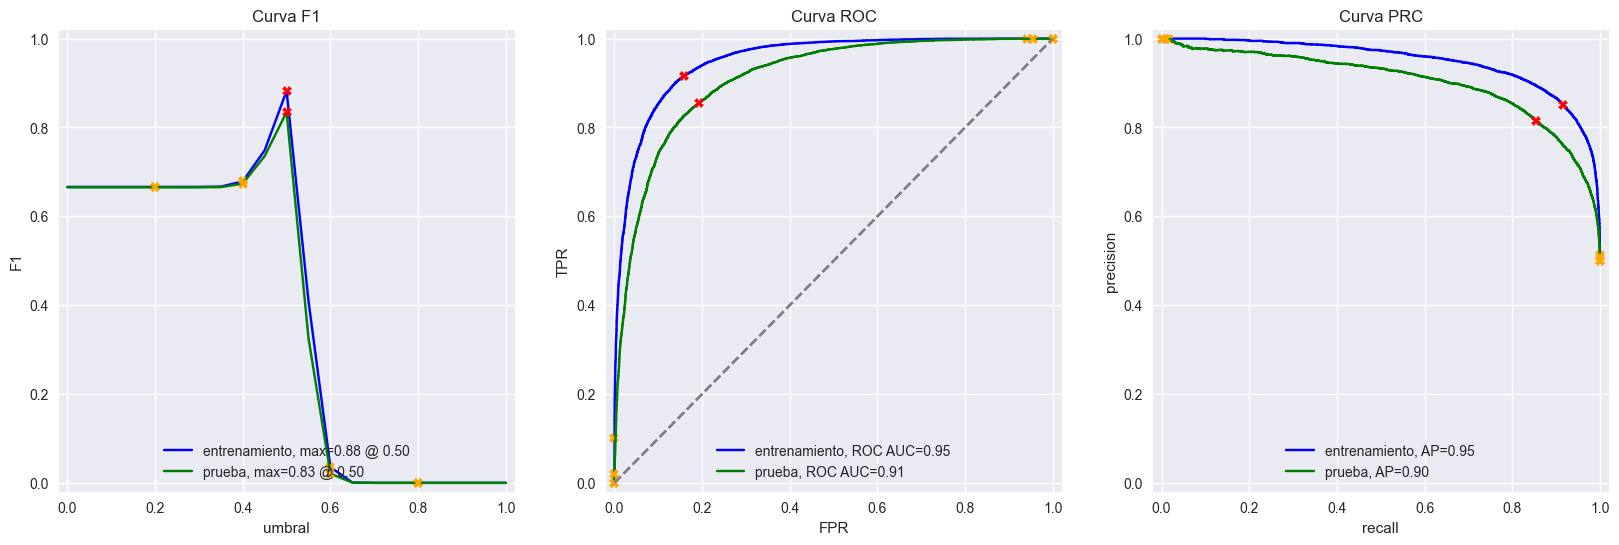

In [36]:
# Evaluación del mejor modelo
start_time_2 = time.time()
result_2 = evaluate_model(best_model_2rf, X_train_nltk, y_train, X_test_nltk, y_test)
end_time_2 = time.time()
elapsed_time_2 = end_time_2 - start_time_2
print()

# Incorporación de resultados a tabla
summary_models.loc['Modelo 2 - RandomForestClassifier'] = {'NPL':'NLTK y TFIDF', 
                                                           'F1 entrenamiento': result_2.iloc[1][0], 
                                                           'F1 prueba': result_2.iloc[1][1],
                                                           'Tiempo de predicción': round(elapsed_time_2, 2)}

**Curva F1:**
La curva de la puntuación F1 para el modelo muestra un aumento pronunciado hasta alcanzar un máximo de 0.88 en entrenamiento y 0.84 en prueba, ambos en un umbral de 0.50, seguido de una caída rápida. Esto indica que el desempeño del modelo es sensible a la elección del umbral, logrando su mejor equilibrio entre precisión y recall en un punto específico. En comparación con modelo de regresión logística, el rendimiento es bueno pero algo menos estable, evidenciado por la caída más abrupta después del umbral óptimo.

**Curva ROC:**
La curva ROC del modelo asciende rápidamente, aunque no tan pronunciadamente como la del modelo anterior, con un área bajo la curva (AUC) de 0.95 en entrenamiento y 0.91 en prueba. Estos valores reflejan una sólida capacidad discriminativa, aunque ligeramente inferior a la regresión.

**Curva PRC:**
La curva de PRC mantiene valores altos, pero comienza a descender más notoriamente a medida que aumenta el recall, con un promedio de precisión (AP) de 0.95 en entrenamiento y 0.91 en prueba. La forma de la curva y la ubicación de los puntos sugieren que, aunque el modelo conserva alta precisión para niveles moderados de recall, su desempeño disminuye al intentar capturar un mayor porcentaje de positivos, evidenciando el clásico compromiso entre precisión y recall en extremos del umbral.

### Modelo 3: LGBMClassifier

El tercer modelo implementado será **LGBMClassifier**, cuyos hiperparámetros se ajustarán mediante validación cruzada para optimizar su rendimiento. Posteriormente, se evaluará su desempeño en los conjuntos de entrenamiento y prueba, utilizando textos que previamente fueron lematizados con NLTK y representados mediante vectores generados por TF-IDF.

In [37]:
# Búsqueda y entrenamiento del mejor modelo
best_params_3lgbm = grid_search_cv(model_lgbm, params_lgbm, X_train_nltk, y_train)
best_model_3lgbm = LGBMClassifier(**best_params_3lgbm)
print()

Mejores parámetros para LGBMClassifier: {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}



           entrenamiento  prueba
Exactitud           0.92    0.85
F1                  0.92    0.85
APS                 0.98    0.93
ROC AUC             0.98    0.93


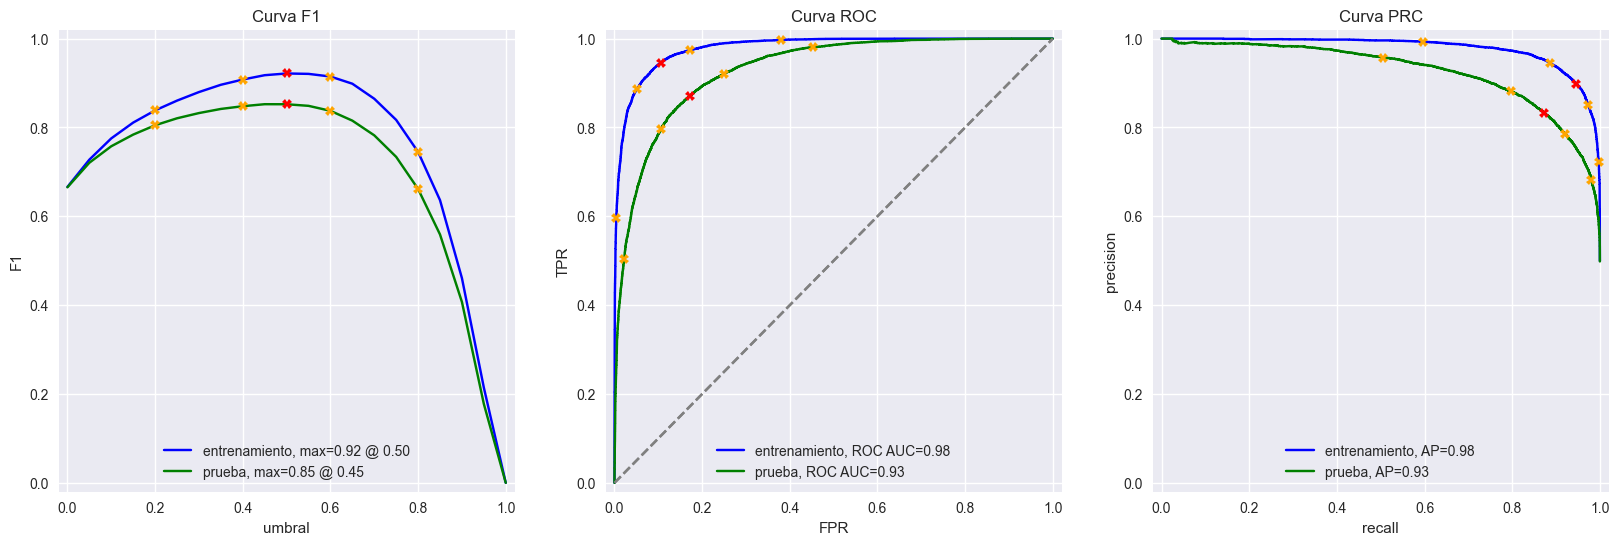

In [38]:
# Evaluación del mejor modelo
start_time_3 = time.time()
result_3 = evaluate_model(best_model_3lgbm, X_train_nltk, y_train, X_test_nltk, y_test)
end_time_3 = time.time()
elapsed_time_3 = end_time_3 - start_time_3

# Incorporación de resultados a tabla
summary_models.loc['Modelo 3 - LGBMClassifier'] = {'NPL':'NLTK y TFIDF', 
                                                   'F1 entrenamiento': result_3.iloc[1][0], 
                                                   'F1 prueba': result_3.iloc[1][1],
                                                   'Tiempo de predicción': round(elapsed_time_3, 2)}

**Curva F1:**
La curva de la puntuación F1 obtenida con el conjunto procesado por spaCy muestra una forma suave y acampanada, alcanzando un pico máximo de 0.92 en el conjunto de entrenamiento (línea azul) con un umbral de 0.50, y 0.85 en el conjunto de prueba (línea verde) con un umbral de 0.45. Esto refleja una calibración adecuada del modelo, ya que la F1 mejora al acercarse al umbral óptimo y disminuye al superarlo. El punto rojo indica el umbral donde se logra la F1 máxima para cada conjunto, mientras que los puntos amarillos marcan otros umbrales evaluados. La diferencia observable entre las curvas de entrenamiento y prueba sugiere un rendimiento robusto, aunque con una ligera indicación de sobreajuste.

**Curva ROC:**
La curva ROC exhibe una ascensión rápida hacia la esquina superior izquierda, lo que evidencia una alta sensibilidad (verdaderos positivos) y especificidad (bajo nivel de falsos positivos). El área bajo la curva (AUC-ROC) es de 0.98 para el conjunto de entrenamiento y 0.93 para el de prueba, demostrando una excelente capacidad del modelo para distinguir entre clases. El punto rojo cercano a la esquina superior izquierda representa un equilibrio óptimo entre la tasa de verdaderos positivos y falsos positivos.

**Curva PRC:**
La curva de Precisión-Recall se mantiene elevada y desplazada hacia la derecha, con precisión cercana a 1 para la mayoría de los valores de *recall*, especialmente en el conjunto de entrenamiento (AP = 0.98) y ligeramente inferior en el conjunto de prueba (AP = 0.93). Esto indica que el modelo conserva un alto nivel de precisión y recall a lo largo de un amplio rango de umbrales, confirmando su desempeño sólido y consistente.

## Modelos con procesamiento de texto Spacy y TF-IDF 

En esta sección de evaluación de modelos para análisis de sentimiento, se aplicará la lematización con spaCy y la vectorización TF-IDF. SpaCy es una biblioteca optimizada para entornos de producción que ofrece un *pipeline* eficiente y preciso, incluyendo lematización basada en modelos estadísticos y reglas lingüísticas integradas. Esta combinación permite procesar grandes volúmenes de texto de forma rápida y con alta calidad, facilitando así el desarrollo de modelos robustos y escalables para tareas de análisis de sentimiento.

In [39]:
# Inicialización del modelo spaCy para procesamiento de texto
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Explicar que se iban a poner POS tags pero que no funcionó

In [40]:
# Función de lematización de texto con spaCy excluyendo puntuación y espacios
def lemmatizer_spacy(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        
        # Filter out punctuation and spaces
        if token.is_punct or token.is_space:
            continue
        
        # Lemmatize all tokens
        lemmas.append(token.lemma_)
    
    return ' '.join(lemmas)

In [41]:
# Lematización
start_time_spacy = time.time()
X_train_lemm_spacy = X_train.progress_apply(lemmatizer_spacy)
X_test_lemm_spacy  = X_test.progress_apply(lemmatizer_spacy)
end_time_spacy = time.time()
elapsed_time_spacy = end_time_spacy - start_time_spacy

# TF-IDF
vectorizer_spacy = TfidfVectorizer()
X_train_spacy = vectorizer_spacy.fit_transform(X_train_lemm_spacy)
X_test_spacy  = vectorizer_spacy.transform(X_test_lemm_spacy)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [42]:
#Visualización de resultados de lematización y resumen de matrices TF-IDF
print('Ejemplo de texto original:\n', train['review'].iloc[100])
print('\nEjemplo de texto lematizado con Spacy:\n', X_train_lemm_spacy.iloc[100])
print()
print('Tiempo de lematización:', round(elapsed_time_spacy,2), 'seg')
print('TF-IDF Matrix X train', X_train_spacy.shape)
print('TF-IDF Matrix X test:', X_test_spacy.shape)

Ejemplo de texto original:
 The plot of this terrible film is so convoluted I've put the spoiler warning up because I'm unsure if I'm giving anything away. The audience first sees some man in Jack the Ripper garb murder an old man in an alley a hundred years ago. Then we're up to modern day and a young Australian couple is looking for a house. We're given an unbelievably long tour of this house and the husband sees a figure in an old mirror. Some 105 year old woman lived there. There are also large iron panels covering a wall in the den. An old fashioned straight-razor falls out when they're renovating and the husband keeps it. I guess he becomes possessed by the razor because he starts having weird dreams. Oh yeah, the couple is unable to have a baby because the husband is firing blanks. Some mold seems to be climbing up the wall after the couple removes the iron panels and the mold has the shape of a person. Late in the story there is a plot about a large cache of money & the husband

Aunque en este caso tampoco se utilizaron etiquetas de POS, observamos que spaCy realizó una lematización más precisa que la herramienta anterior. Por ejemplo, palabras como *convoluted*, *giving* y *seems*, que no fueron correctamente lematizadas previamente, fueron transformadas adecuadamente por spaCy a sus formas base: *convolute*, *give* y *seem*, respectivamente. Esto se debe a que spaCy incorpora modelos estadísticos y reglas lingüísticas que, incluso sin etiquetas POS explícitas, permiten una mejor identificación del lema correcto en inglés. 

### Modelo 4: LogisticRegressionClassifier

In [43]:
# Búsqueda y entrenamiento de mejor modelo
best_params_4lr = grid_search_cv(model_lr, params_lr, X_train_spacy, y_train)
best_model_4lr = LogisticRegression(**best_params_4lr)
print()

Mejores parámetros para LogisticRegression: {'C': 1.0, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}



           entrenamiento  prueba
Exactitud           0.93    0.88
F1                  0.93    0.88
APS                 0.98    0.95
ROC AUC             0.98    0.95


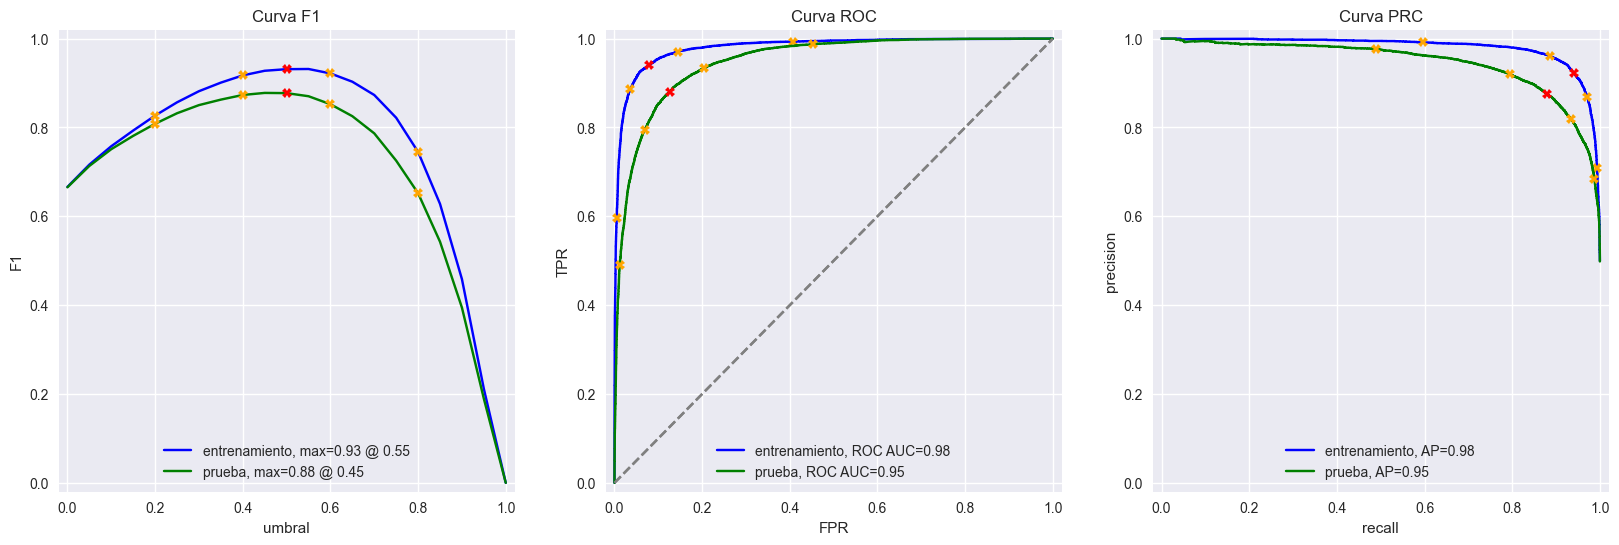

In [44]:
# Evaluación del mejor modelo
start_time_4 = time.time()
result_4 = evaluate_model(best_model_4lr, X_train_spacy, y_train, X_test_spacy, y_test)
end_time_4 = time.time()
elapsed_time_4 = end_time_4 - start_time_4

# Incorporación de resultados a tabla
summary_models.loc['Modelo 4 - LogisticRegression'] = {'NPL':'Spacy y TFIDF',
                                                       'F1 entrenamiento': result_4.iloc[1][0], 
                                                       'F1 prueba': result_4.iloc[1][1],
                                                       'Tiempo de predicción': round(elapsed_time_4, 2)}

**Curva F1:**
La curva de la puntuación F1 para el conjunto que utilizó spaCy presenta una forma suave y acampanada, alcanzando un máximo de 0.93 en el conjunto de entrenamiento (color azul) con un umbral de 0.55, y 0.88 en el conjunto de prueba (color verde) con un umbral de 0.45. Esto indica que el modelo está bien calibrado, ya que la F1 aumenta conforme el umbral se acerca al valor óptimo y disminuye al sobrepasarlo. El punto rojo señala el umbral donde se obtiene la máxima F1 en cada conjunto, mientras que los puntos amarillos representan otros umbrales evaluados. La diferencia entre las curvas de entrenamiento y prueba sugiere un rendimiento fuerte, aunque con una ligera tendencia al sobreajuste.

**Curva ROC:**
La curva ROC muestra una subida pronunciada hacia la esquina superior izquierda, lo que refleja alta sensibilidad (tasa de verdaderos positivos) y especificidad (baja tasa de falsos positivos). El área bajo la curva (ROC AUC) es 0.98 para entrenamiento y 0.95 para prueba, evidenciando una excelente capacidad discriminativa del modelo. La ubicación del punto rojo cerca de la esquina superior izquierda representa un balance óptimo entre tasa de verdaderos positivos y tasa de falsos positivos.

**Curva PRC:**
La curva de Precisión-Recall (PRC) se mantiene alta y desplazada hacia la derecha, con precisión cercana a 1 para la mayoría de los valores de *recall*, especialmente en entrenamiento (AP = 0.98) y ligeramente menor en prueba (AP = 0.95). Esto indica que el modelo mantiene un alto nivel de precisión y *recall* en un amplio rango de umbrales, confirmando su sólido desempeño.

### Modelo 5: RandomForestClassifier

In [45]:
# Búsqueda y entrenamiento de mejor modelo
best_params_5rf = grid_search_cv(model_rf, params_rf, X_train_spacy, y_train)
best_model_5rf = RandomForestClassifier(**best_params_5rf)
print()

Mejores parámetros para RandomForestClassifier: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}



           entrenamiento  prueba
Exactitud           0.87    0.83
F1                  0.88    0.83
APS                 0.95    0.90
ROC AUC             0.95    0.91


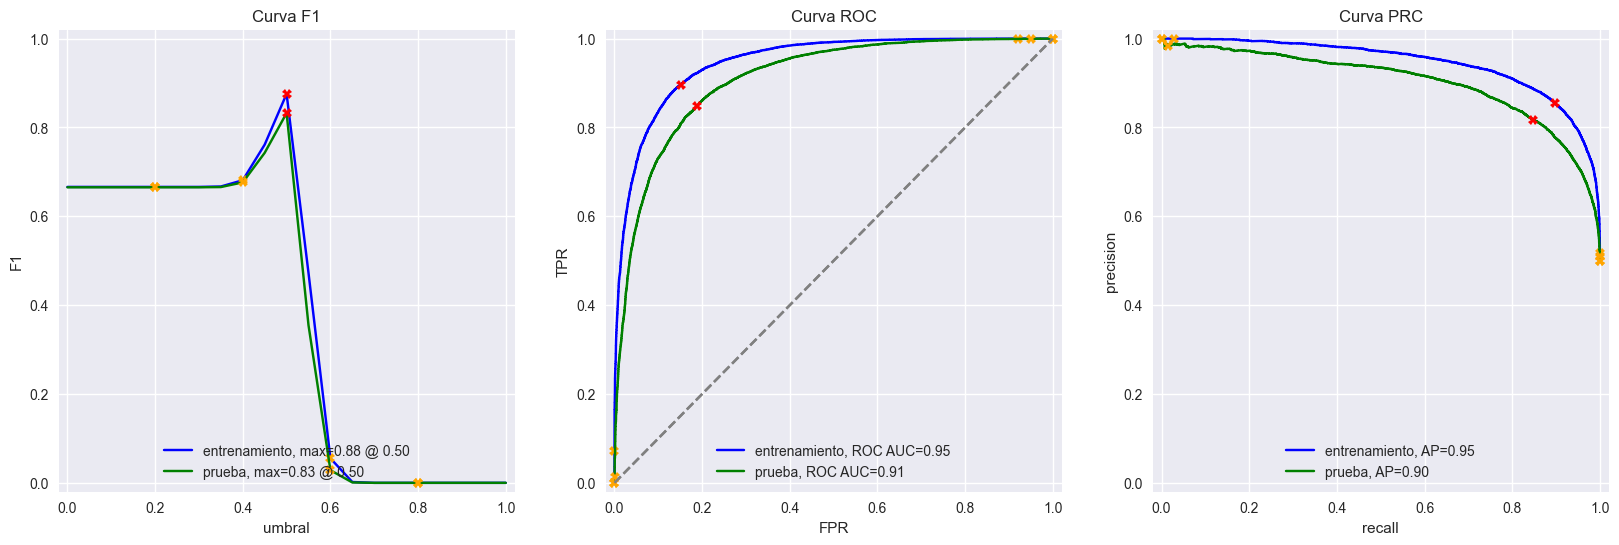

In [46]:
# Evaluación del mejor modelo
start_time_5 = time.time()
result_5 = evaluate_model(best_model_5rf, X_train_spacy, y_train, X_test_spacy, y_test)
end_time_5 = time.time()
elapsed_time_5 = end_time_5 - start_time_5

# Incorporación de resultados a tabla
summary_models.loc['Modelo 5 - RandomForestClassifier'] = {'NPL':'Spacy y TFIDF', 
                                                           'F1 entrenamiento': result_5.iloc[1][0], 
                                                           'F1 prueba': result_5.iloc[1][1],
                                                           'Tiempo de predicción': round(elapsed_time_5, 2)}

**Curva F1:**
La curva de la puntuación F1 para el modelo muestra un aumento pronunciado hasta alcanzar un máximo de 0.88 en entrenamiento y 0.83 en prueba, ambos en un umbral de 0.50, seguido de una caída rápida. Esto indica que el desempeño del modelo es sensible a la elección del umbral, logrando su mejor equilibrio entre precisión y recall en un punto específico. En comparación con modelo de regresión logística, el rendimiento es bueno pero algo menos estable, evidenciado por la caída más abrupta después del umbral óptimo.

**Curva ROC:**
La curva ROC del modelo asciende rápidamente, aunque no tan pronunciadamente como la del modelo anterior, con un área bajo la curva (AUC) de 0.95 en entrenamiento y 0.91 en prueba. Estos valores reflejan una sólida capacidad discriminativa, aunque ligeramente inferior a la regresión.

**Curva PRC:**
La curva de PRC mantiene valores altos, pero comienza a descender más notoriamente a medida que aumenta el recall, con un promedio de precisión (AP) de 0.95 en entrenamiento y 0.90 en prueba. La forma de la curva y la ubicación de los puntos sugieren que, aunque el modelo conserva alta precisión para niveles moderados de recall, su desempeño disminuye al intentar capturar un mayor porcentaje de positivos, evidenciando el clásico compromiso entre precisión y recall en extremos del umbral.

### Modelo 6: LGBMClassifier

In [47]:
# Búsqueda y entrenamiento de mejor modelo
best_params_6lgbm = grid_search_cv(model_lgbm, params_lgbm, X_train_spacy, y_train)
best_model_6lgbm = LGBMClassifier(**best_params_6lgbm)
print()

Mejores parámetros para LGBMClassifier: {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}



           entrenamiento  prueba
Exactitud           0.92    0.85
F1                  0.92    0.85
APS                 0.98    0.93
ROC AUC             0.98    0.93


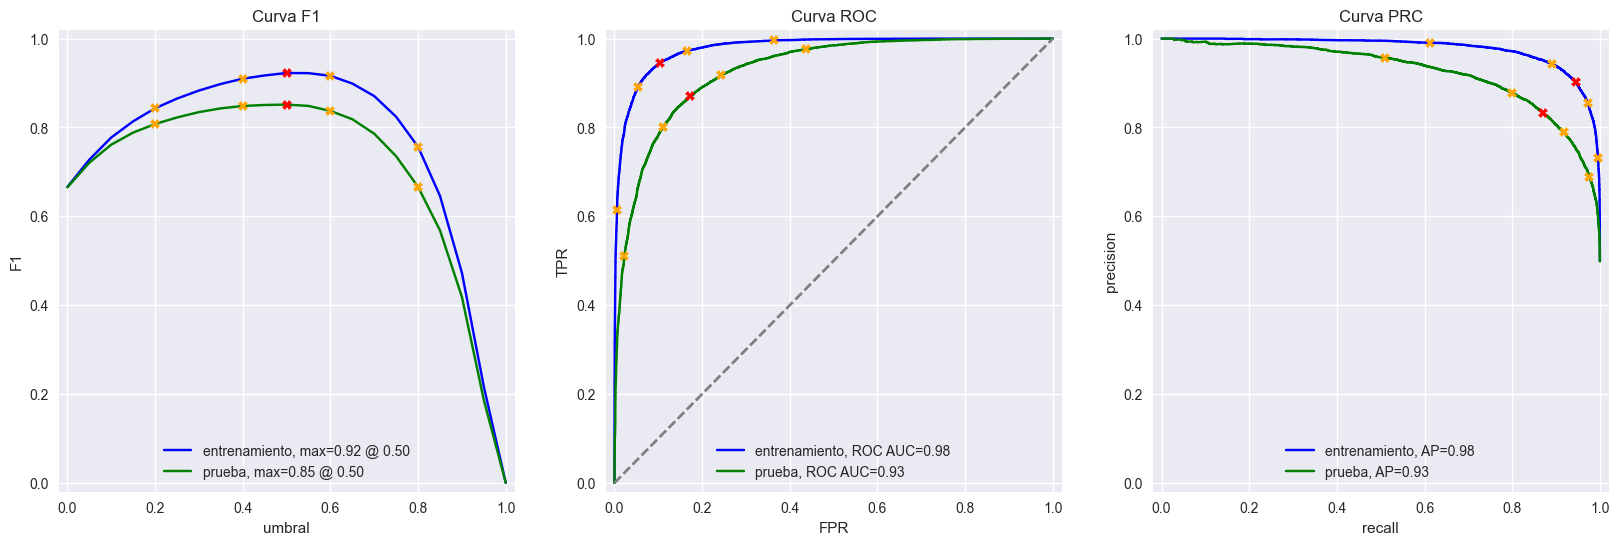

In [48]:
# Evaluación del mejor modelo
start_time_6 = time.time()
result_6 = evaluate_model(best_model_6lgbm, X_train_spacy, y_train, X_test_spacy, y_test)
end_time_6 = time.time()
elapsed_time_6 = end_time_6 - start_time_6

# Incorporación de resultados a tabla
summary_models.loc['Modelo 6 - LGBMClassifier'] = {'NPL':'Spacy y TFIDF', 
                                                   'F1 entrenamiento': result_6.iloc[1][0], 
                                                   'F1 prueba': result_6.iloc[1][1],
                                                   'Tiempo de predicción': round(elapsed_time_6, 2)}

**Curva F1:**
La curva de la puntuación F1 obtenida con el conjunto procesado por spaCy muestra una forma suave y acampanada, alcanzando un pico máximo de 0.92 en el conjunto de entrenamiento (línea azul) con un umbral de 0.50, y 0.85 en el conjunto de prueba (línea verde) en el mismo umbral. Esto refleja una calibración adecuada del modelo, ya que la F1 mejora al acercarse al umbral óptimo y disminuye al superarlo. El punto rojo indica el umbral donde se logra la F1 máxima para cada conjunto, mientras que los puntos amarillos marcan otros umbrales evaluados. La diferencia observable entre las curvas de entrenamiento y prueba sugiere un rendimiento robusto, aunque con una ligera indicación de sobreajuste.

**Curva ROC:**
La curva ROC exhibe una ascensión rápida hacia la esquina superior izquierda, lo que evidencia una alta sensibilidad (verdaderos positivos) y especificidad (bajo nivel de falsos positivos). El área bajo la curva (AUC-ROC) es de 0.98 para el conjunto de entrenamiento y 0.93 para el de prueba, demostrando una excelente capacidad del modelo para distinguir entre clases. El punto rojo cercano a la esquina superior izquierda representa un equilibrio óptimo entre la tasa de verdaderos positivos y falsos positivos.

**Curva PRC:**
La curva de Precisión-Recall se mantiene elevada y desplazada hacia la derecha, con precisión cercana a 1 para la mayoría de los valores de *recall*, especialmente en el conjunto de entrenamiento (AP = 0.98) y ligeramente inferior en el conjunto de prueba (AP = 0.93). Esto indica que el modelo conserva un alto nivel de precisión y recall a lo largo de un amplio rango de umbrales, confirmando su desempeño sólido y consistente.

## Modelos con procesamiento de texto con BERT¶

In [49]:
# Carga y configuración del modelo BERT preentrenado 
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [50]:
# Función de extracción de embeddings de texto con BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):
     
    # Lista de ids de tokens y máscaras de atención
    ids_list = [] 
    attention_mask_list = [] 

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length) 
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    # Dispositivo a usar para ejecutar operaciones con PyTorch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Uso del dispositivo {device}.')
    model.to(device)

    # Procesamiento en lotes
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        # Creación de lote de ids de tokens. Unión de vectores ids a un tensor
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i : batch_size*(i+1)])).to(device)
        
        # Creación de lote de máscaras de atención. Unión de vectores de máscara a un tensor
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_size*i : batch_size*(i+1)])).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [51]:
# Segmentación de conjuntos de características (200)
X_train_200 = train['review_norm'].iloc[0:200]
X_test_200  = test['review_norm'].iloc[0:200]

# Segmentación de conjuntos de objeticos (200)
y_train_bert = train['pos'].iloc[0:200]
y_test_bert  = test['pos'].iloc[0:200]

In [52]:
# Extracción de embeddings para conjunto de entrenamiento y prueba
X_train_bert = BERT_text_to_embeddings(X_train_200)
X_test_bert = BERT_text_to_embeddings(X_test_200)
end_time_bert = time.time()

# Muestra de dimensiones de los embeddings
print(X_train_bert.shape)
print(y_train_bert.shape)
print()
print(X_test_bert.shape)
print(y_test_bert.shape)

Uso del dispositivo cpu.


  0%|          | 0/8 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/8 [00:01<?, ?it/s]

(200, 768)
(200,)

(200, 768)
(200,)


### Modelo 7: LogisticRegressionClassifier

In [53]:
# Búsqueda y entrenamiento de mejor modelo
best_params_7lr = grid_search_cv(model_lr, params_lr, X_train_bert, y_train_bert)
best_model_7lr = LogisticRegression(**best_params_7lr)
print()

Mejores parámetros para LogisticRegression: {'C': 1.0, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}



           entrenamiento  prueba
Exactitud           1.00    0.70
F1                  0.99    0.64
APS                 1.00    0.87
ROC AUC             1.00    0.84


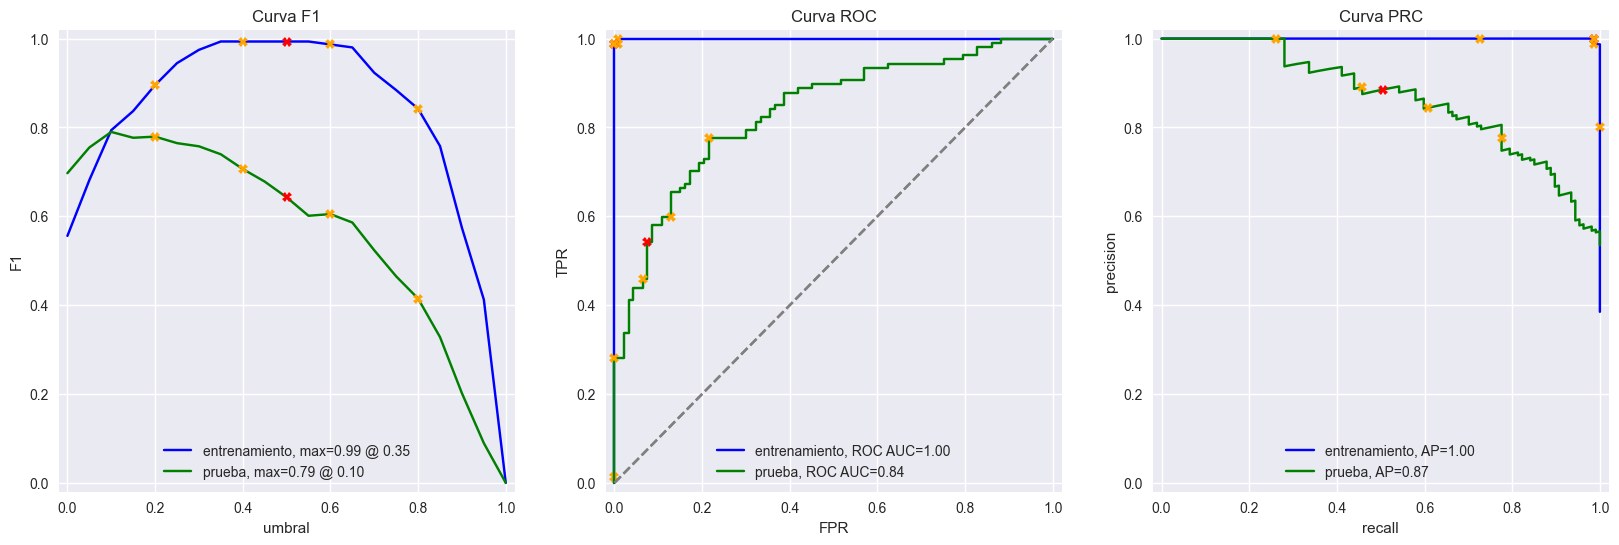

In [54]:
# Evaluación del mejor modelo
start_time_7 = time.time()
result_7 = evaluate_model(best_model_7lr, X_train_bert, y_train_bert, X_test_bert, y_test_bert)
end_time_7 = time.time()
elapsed_time_7 = end_time_7 - start_time_7

# Incorporación de resultados a tabla
summary_models.loc['Modelo 7 - LogisticRegression'] = {'NPL':'BERT',
                                                       'F1 entrenamiento': result_7.iloc[1][0], 
                                                       'F1 prueba': result_7.iloc[1][1],
                                                       'Tiempo de predicción': round(elapsed_time_7, 2)}

**Curva F1:** La curva F1 para el modelo de regresión logística muestra un comportamiento abrupto, con valores que suben rápidamente hasta 1.0 en entrenamiento y luego caen de manera igualmente brusca. En el conjunto de prueba, la curva es mucho más irregular y nunca alcanza valores tan altos, con un máximo de 0.77. Esto indica que el modelo está sobreajustado: en entrenamiento, predice perfectamente  datos), mientras que en prueba su desempeño es mucho menor y la curva no es suave porque hay muy pocos valores a predecir, con pocas probabilidades intermedias.

**Curva ROC:** La curva ROC en entrenamiento es una línea perfecta en el eje superior izquierdo, con un AUC de 1.0, lo que indica que el modelo distingue perfectamente entre clases en entrenamiento. Sin embargo, en prueba, la curva baja considerablemente (AUC=0.82) y muestra saltos, lo que refleja que el modelo no generaliza bien y que hay pocos umbrales donde realmente cambia la decisión del modelo.

**Curva PRC:** La curva de PRC también es perfecta en entrenamiento (AP=1.0), pero en prueba baja a 0.83 y muestra una serie de escalones. La forma abrupta indica que el modelo toma decisiones muy “duras” y no tiene una transición suave entre clases.

### Modelo 8: RandomForestClassifier

In [55]:
# Búsqueda y entrenamiento de mejor modelo
best_params_8rf = grid_search_cv(model_rf, params_rf, X_train_bert, y_train_bert)
best_model_8rf = RandomForestClassifier(**best_params_8rf)
print()

Mejores parámetros para RandomForestClassifier: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}



           entrenamiento  prueba
Exactitud            1.0    0.64
F1                   1.0    0.54
APS                  1.0    0.80
ROC AUC              1.0    0.79


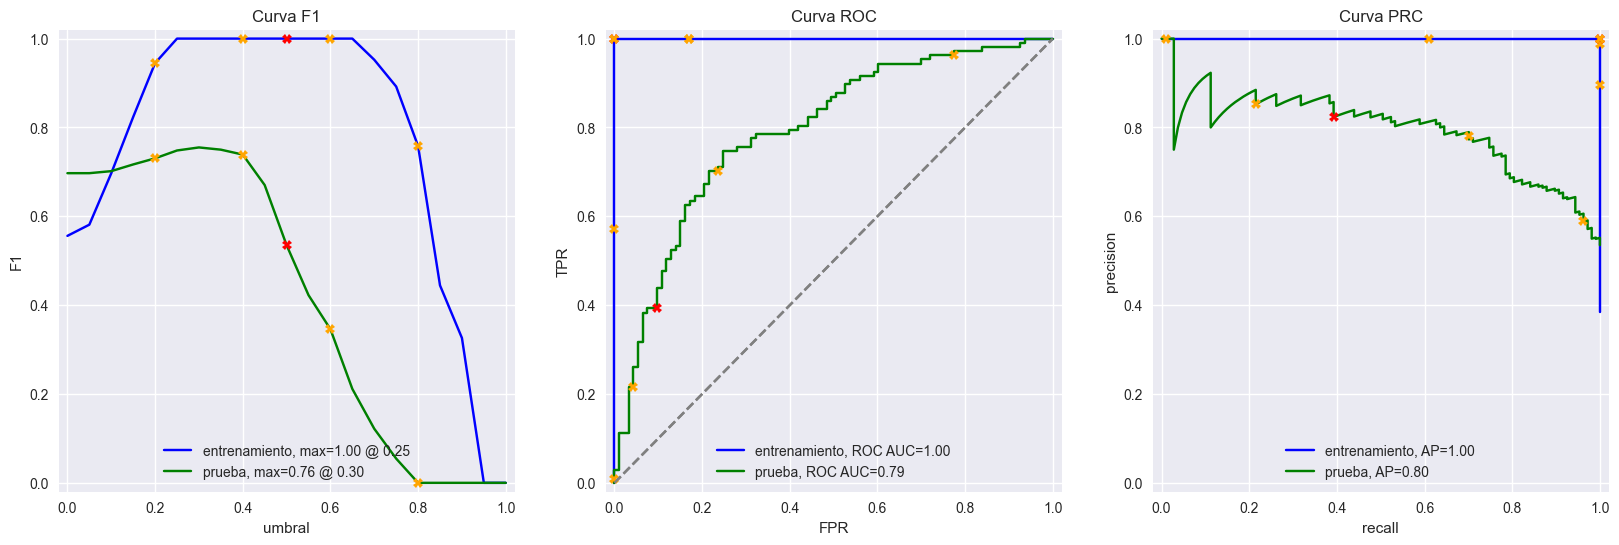

In [56]:
# Evaluación del mejor modelo
start_time_8 = time.time()
result_8 = evaluate_model(best_model_8rf, X_train_bert, y_train_bert, X_test_bert, y_test_bert)
end_time_8 = time.time()
elapsed_time_8 = end_time_8 - start_time_8

# Incorporación de resultados a tabla
summary_models.loc['Modelo 8 - RandomForestClassifier'] = {'NPL':'BERT', 
                                                           'F1 entrenamiento': result_8.iloc[1][0], 
                                                           'F1 prueba': result_8.iloc[1][1],
                                                           'Tiempo de predicción': round(elapsed_time_8, 2)}

**Curva F1:** En el bosque aleatorio, la curva F1 de entrenamiento también es abrupta y alcanza 1.0, pero en prueba el máximo es 0.77 y la curva es aún más irregular y baja rápidamente conforme se cambia el umbral. Esto indica que el modelo está sobreajustando.

**Curva ROC:** La curva ROC en entrenamiento es perfecta (AUC=1.0), mientras que en prueba baja a 0.79, con una forma escalonada. Esto se debe a que los bosques aleatorios, aunque generan probabilidades, tienden a producir valores agrupados, por lo que hay pocos puntos diferentes en el eje de umbrales.

**Curva PRC:** La curva PRC muestra precisión perfecta en entrenamiento (AP=1.0), pero en prueba baja a 0.79 y es muy irregular.

### Modelo 9: LGBMClassifier

In [57]:
# Búsqueda y entrenamiento de mejor modelo
best_params_9lgbm = grid_search_cv(model_lgbm, params_lgbm, X_train_bert, y_train_bert)
best_model_9lgbm = LGBMClassifier(**best_params_9lgbm)
print()

Mejores parámetros para LGBMClassifier: {'max_depth': 8, 'n_estimators': 150, 'objective': 'binary'}



           entrenamiento  prueba
Exactitud            1.0    0.67
F1                   1.0    0.62
APS                  1.0    0.83
ROC AUC              1.0    0.82


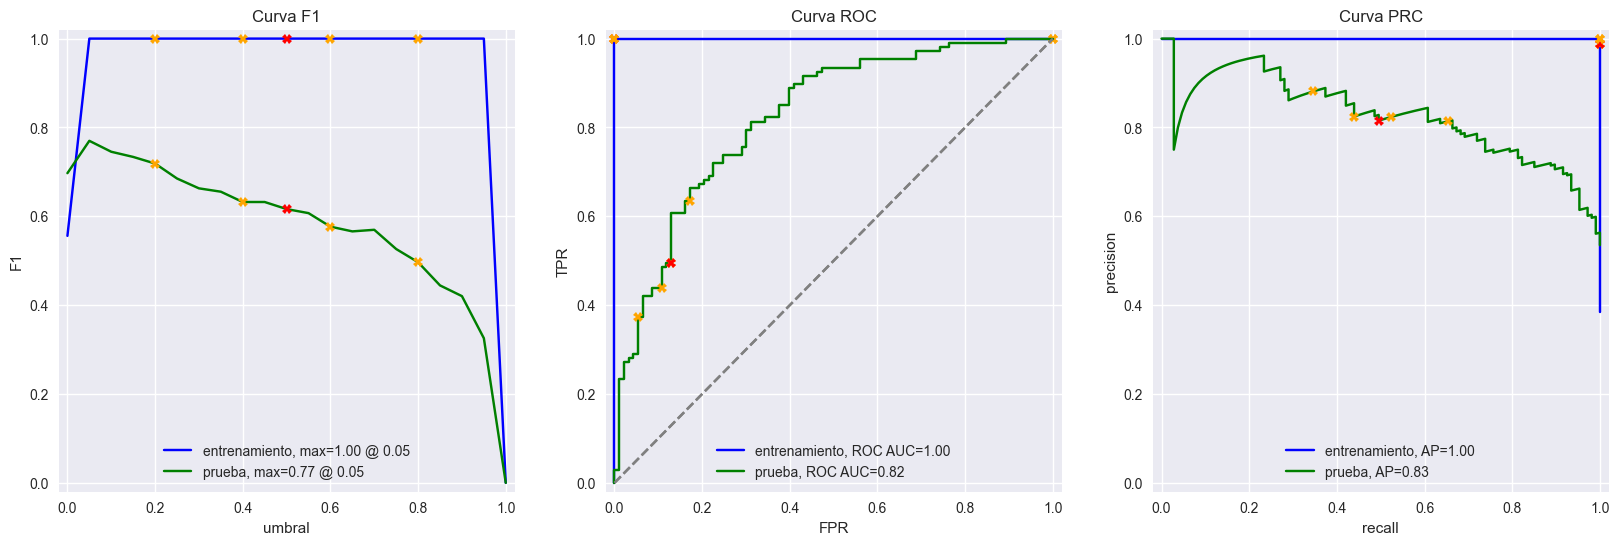

In [58]:
# Evaluación del mejor modelo
start_time_9 = time.time()
result_9 = evaluate_model(best_model_9lgbm, X_train_bert, y_train_bert, X_test_bert, y_test_bert)
end_time_9 = time.time()
elapsed_time_9 = end_time_9 - start_time_9

# Incorporación de resultados a tabla
summary_models.loc['Modelo 9 - LGBMClassifier'] = {'NPL':'BERT', 
                                                   'F1 entrenamiento': result_9.iloc[1][0], 
                                                   'F1 prueba': result_9.iloc[1][1],
                                                   'Tiempo de predicción': round(elapsed_time_9, 2)}

**Curva F1:** Para el modelo LGBM, la curva F1 en entrenamiento es una meseta casi perfecta (máx 0.99), mientras que en prueba el máximo es 0.79 y la curva es menos suave de lo esperado. Esto indica sobreajuste: el modelo aprende demasiado bien el entrenamiento y no generaliza. La forma abrupta se debe a que, aunque LGBM genera probabilidades, en conjuntos pequeños o desbalanceados hay pocos valores intermedios, por lo que la métrica cambia bruscamente al modificar el umbral.

**Curva ROC:** La curva ROC de entrenamiento es casi perfecta (AUC=1.0), mientras que en prueba es 0.84, mostrando una forma escalonada. Esto refleja sobreajuste y la falta de generalización.

**Curva PRC:** La curva PRC en entrenamiento es casi perfecta (AP=1.0), pero en prueba baja a 0.87. La curva es abrupta y escalonada, lo que indica que el modelo toma decisiones muy marcadas y no tiene una transición suave entre clases.

## Resultados

In [59]:
# Muestra de tabla de resultados
summary_models

,NPL,F1 entrenamiento,F1 prueba,Tiempo de predicción
modelo,,,,
Modelo o - DummyClassifier,normalizador,0.50,0.51,1.27
Modelo 1 - LogisticRegression,NLTK y TFIDF,0.94,0.88,4.53
Modelo 2 - RandomForestClassifier,NLTK y TFIDF,0.88,0.83,33.59
Modelo 3 - LGBMClassifier,NLTK y TFIDF,0.92,0.85,180.17
Modelo 4 - LogisticRegression,Spacy y TFIDF,0.93,0.88,4.62
Modelo 5 - RandomForestClassifier,Spacy y TFIDF,0.88,0.83,32.02
Modelo 6 - LGBMClassifier,Spacy y TFIDF,0.92,0.85,176.57
Modelo 7 - LogisticRegression,BERT,0.99,0.64,10.18
Modelo 8 - RandomForestClassifier,BERT,1.00,0.54,7.62


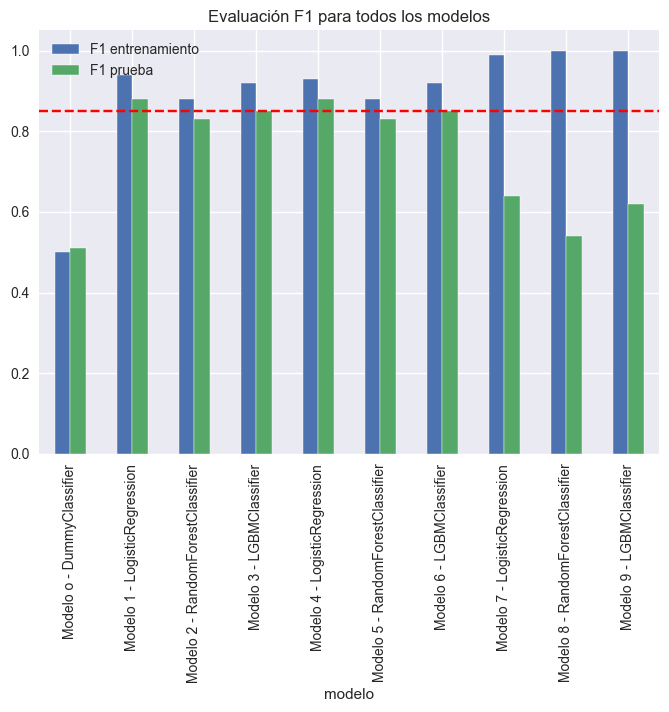

In [60]:
# Comparación visual del desempeño F1 de todos los modelos
summary_models.loc[:, summary_models.columns != 'Tiempo de predicción'].plot(
    kind='bar', title='Evaluación F1 para todos los modelos')
plt.axhline(y=0.85, color='red', ls='--')
plt.show()


Todos los modelos superaron el desempeño del modelo base, DummyClassifier. Los modelos 1, 3, 4 y 6destacan por superar ampliamente el umbral de éxito de 0.85 en F1 prueba, con valores de 0.88, 0.85, 0.88 y 0.85 respectivamente, mostrando un rendimiento sólido en clasificación. Los modelos 2 y 5, aunque tienen buenos F1 entrenamiento (0.88), no alcanzan el umbral en prueba (0.83), indicando posible sobreajuste. Los modelos basados en BERT (7, 8 y 9) presentan sobreajuste extremo con F1 entrenamiento cercano a 1 pero F1 prueba muy bajo (0.54-0.64), descartándolos para uso práctico.

En cuanto a tiempos de predicción, los modelos LogisticRegression (1 y 4) son los más eficientes, con tiempos cercanos a 4.5 segundos, mientras que RandomForest (2 y 5) y LGBM (3 y 6) requieren mucho más tiempo, especialmente LGBM que supera los 170 segundos. Los modelos BERT tienen tiempos intermedios (7-10 segundos) pero su baja precisión los hace poco recomendables.

**Recomendación:** Para un balance óptimo entre eficacia y eficiencia, los modelos 1 y 4 (LogisticRegression con lematización NLTK o Spacy) son los más adecuados, ya que combinan un alto F1 (>0.85) con tiempos de predicción bajos. Los modelos 3 y 6 (LGBM) también son efectivos en F1 pero menos prácticos por su alto tiempo de predicción. Debido a las limitantes tecnológicas que hubo en este proyecto, los modelos que utilizaron BERT tuvieron un bajo rendimiento por lo que no se recomiendan.

# Reseñas cortas

A continuación, se analizará el desempeño de los mejores modelos cuando se enfrentan a reseñas muy breves, con una longitud de entre 7 y 26 palabras antes de la lematización. El objetivo es evaluar si los modelos mantienen su capacidad predictiva con información limitada o si requieren un mayor volumen de datos para generar predicciones precisas.

In [61]:
# Muestra de reseñas
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# 

# Normalización de las reseñas
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews['feeling'] = [0, 0, 1, 0, 1, 1, 0, 1]

# Conjuntos de características y objetivos
features = my_reviews['review_norm']
target = my_reviews['feeling']

# Muestra de texto normalizado
my_reviews

,review,review_norm,feeling
0,"I did not simply like it, not my kind of movie.",simply like kind movie,0
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie,0
2,I was really fascinated with the movie,really fascinated movie,1
3,Even the actors looked really old and disinter...,even actors looked really old disinterested go...,0
4,I didn't expect the reboot to be so good! Writ...,expect reboot good writers really cared source...,1
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall dece...,1
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke lands everyo...,0
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...,1


## Predicciones

In [62]:
# Lematización y vectorización de características
features_nltk = features.progress_apply(lemmatizer_nltk)
features_nltk = vectorizer_nltk.transform(features_nltk)

features_spacy = features.progress_apply(lemmatizer_spacy)
features_spacy = vectorizer_spacy.transform(features_spacy)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [63]:
# Entrenamiento de modelos
best_model_1lr.fit(X_train_nltk, y_train)
best_model_3lgbm.fit(X_train_nltk, y_train)
best_model_4lr.fit(X_train_spacy, y_train)
best_model_6lgbm.fit(X_train_spacy, y_train)

# Cálculo de predicciones con los mejores modelos
my_reviews['pred_m1'] = best_model_1lr.predict(features_nltk)
my_reviews['pred_m3']  = best_model_3lgbm.predict(features_nltk)
my_reviews['pred_m4'] = best_model_4lr.predict(features_spacy)
my_reviews['pred_m6']  = best_model_6lgbm.predict(features_spacy)

In [64]:
# Columns with predictions
pred_cols = ['pred_m1', 'pred_m3', 'pred_m4', 'pred_m6']

# Calculate F1 scores and store in a dictionary
f1_scores = {}
for col in pred_cols:
    f1 = f1_score(my_reviews['feeling'], my_reviews[col]).round(2)
    f1_scores[col] = f1

# Convert to DataFrame for display
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Modelo', 'F1'])

display(my_reviews.drop('review_norm', axis=1))
display(f1_df)

,review,feeling,pred_m1,pred_m3,pred_m4,pred_m6
0,"I did not simply like it, not my kind of movie.",0,0,1,0,1
1,"Well, I was bored and felt asleep in the middl...",0,0,1,0,1
2,I was really fascinated with the movie,1,1,1,1,1
3,Even the actors looked really old and disinter...,0,0,0,0,1
4,I didn't expect the reboot to be so good! Writ...,1,0,1,0,1
5,"The movie had its upsides and downsides, but I...",1,1,1,1,1
6,What a rotten attempt at a comedy. Not a singl...,0,0,0,0,0
7,Launching on Netflix was a brave move & I real...,1,1,1,1,1


,Model,F1_Score
0,pred_m1,0.86
1,pred_m3,0.80
2,pred_m4,0.86
3,pred_m6,0.73


Los resultados indican que la regresión logística, tanto con lematización realizada mediante NLTK como con spaCy, alcanza el mejor desempeño con un F1 de 0.86, reflejando un balance sólido entre precisión y recall en la predicción de sentimiento. Este rendimiento es consistente con el observado previamente en análisis con reseñas más extensas. Por otro lado, el modelo LightGBM muestra un desempeño intermedio con un F1 de 0.80 al utilizar lematización con NLTK, pero su rendimiento disminuye a 0.73 cuando se emplea la lematización de spaCy. Esta diferencia sugiere que LightGBM es más sensible a la calidad y cantidad de lemas disponibles, afectando su capacidad para clasificar correctamente las clases positivas y negativas en contextos con textos breves.

# Conclusiones

* Se utilizaron herramientas avanzadas de Python para procesamiento de lenguaje natural (NLTK, spaCy), aprendizaje automático (scikit-learn, LightGBM), y visualización (matplotlib, seaborn). El conjunto de datos contiene más de 47,000 reseñas de IMDB, con etiquetas de polaridad (positiva/negativa).

* Se eliminaron los registros con valores faltantes y se hizo la conversión y corrección de tipos de datos en columnas numéricas, así como la imputación de valores faltantes en la duración de películas y eliminación de columnas irrelevantes.

* En el EDA se observó un crecimiento sostenido en la producción de películas y reseñas desde 1980 hasta 2010. Asimismo, as reseñas positivas y negativas están casi equilibradas, tanto en entrenamiento como en prueba. El dataset solo incluye reseñas con puntuaciones extremas (1-4 y 7-10), lo que elimina opiniones neutras. La mayoría de las películas tiene pocas reseñas, aunque hay algunas con un número mucho mayor.

* Se implementó una función para limpiar y normalizar las reseñas, eliminando palabras vacías y aplicando lematización. Posteriomente, se hizo una separación clara entre conjuntos de entrenamiento y prueba, asegurando una evaluación justa.

* **Modelos probados:**

    * **Clasificador base (DummyClassifier):** Sirve como línea base, con desempeño cercano al azar.
      
    * **Regresión logística, Random Forest, LightGBM:** Probados con dos enfoques de lematización (NLTK y spaCy) y vectorización TF-IDF.
      
    * **Modelos con BERT:** Se probaron embeddings de BERT, pero solo en un subconjunto pequeño por limitaciones computacionales.
      

* **Resultados clave:**

    * **Regresión logística (NLTK/Spacy + TF-IDF):** F1 prueba de 0.88, rápido y eficiente.
      
    * **LightGBM:** F1 de 0.85, pero con tiempos de predicción mucho mayores.
      
    * **Random Forest:** F1 de 0.83, por debajo del umbral deseado.
      
    * **Modelos con BERT:** Sobreajuste extremo, bajo desempeño en prueba (F1 < 0.65).

* Los mejores modelos (regresión logística con NLTK o spaCy) mantienen un F1 de 0.86 incluso en reseñas de pocas palabras, mostrando robustez.

* **Recomendaciones:**

    * Usar regresión logística con spaCy o NLTK + TF-IDF: Es rápido, preciso (F1 > 0.85) y fácil de mantener.

    * Considerar ampliar el dataset en el futuro, Incluir reseñas neutras para mejorar la generalización.